In [1]:
# Install packages
!pip install -r requirements.txt >/dev/null
!pip install eep153_tools >/dev/null
!pip install gnupg 
!pip install gspread_pandas >/dev/null

# Import libraries
import numpy as np
import pandas as pd
import warnings
import fooddatacentral as fdc
from  scipy.optimize import linprog as lp
import plotly.express as px
from eep153_tools.sheets import read_sheets

# API Key
apikey = "Y7y8evhwYYL589qVEZzdHBCyKGeBkNdDWQfnWyIV"


In [2]:
# Read diet minimum data
diet_min = pd.read_csv("Spreadsheets/diet_min.csv",index_col=0)
diet_min

Source   C 1-3   F 4-8   M 4-8  F 9-13  M 9-13  \
Nutrition                                                                       
Energy                            ---  1000.0  1200.0  1400.0  1600.0  1800.0   
Protein                           RDA    13.0    19.0    19.0    34.0    34.0   
Fiber, total dietary              ---    14.0    16.8    19.6    22.4    25.2   
Folate, DFE                       RDA   150.0   200.0   200.0   300.0   300.0   
Calcium, Ca                       RDA   700.0  1000.0  1000.0  1300.0  1300.0   
Carbohydrate, by difference       RDA   130.0   130.0   130.0   130.0   130.0   
Iron, Fe                          RDA     7.0    10.0    10.0     8.0     8.0   
Magnesium, Mg                     RDA    80.0   130.0   130.0   240.0   240.0   
Niacin                            RDA     6.0     8.0     8.0    12.0    12.0   
Phosphorus, P                     RDA   460.0   500.0   500.0  1250.0  1250.0   
Potassium, K                       AI  3000.0  3800.0  3800.0  4500.0  4500.0   
Riboflavin                        RDA     0.5     0.6     0.6     0.9     0.9   
Thiamin                           RDA     0.5     0.6     0.6     0.9     0.9   
Vitamin A, RAE                    RDA   300.0   400.0   400.0   600.0   600.0   
Vitamin B-12                      RDA     0.9     1.2     1.2     1.8     1.8   
Vitamin B-6                       RDA     0.5     0.6     0.6     1.0     1.0   
Vitamin C, total ascorbic acid    RDA    15.0    25.0    25.0    45.0    45.0   
Vitamin E (alpha-tocopherol)      RDA     6.0     7.0     7.0    11.0    11.0   
Vitamin K (phylloquinone)          AI    30.0    55.0    55.0    60.0    60.0   
Zinc, Zn                          RDA     3.0     5.0     5.0     8.0     8.0   

                                F 14-18  M 14-18  F 19-30  M 19-30  F 31-50  \
Nutrition                                                                     
Energy                           1800.0   2200.0   2000.0   2400.0   1800.0   
Protein                            46.0     52.0     46.0     56.0     46.0   
Fiber, total dietary               25.2     30.8     28.0     33.6     25.2   
Folate, DFE                       400.0    400.0    400.0    400.0    400.0   
Calcium, Ca                      1300.0   1300.0   1000.0   1000.0   1000.0   
Carbohydrate, by difference       130.0    130.0    130.0    130.0    130.0   
Iron, Fe                           15.0     11.0     18.0      8.0     18.0   
Magnesium, Mg                     360.0    410.0    310.0    400.0    320.0   
Niacin                             14.0     16.0     14.0     16.0     14.0   
Phosphorus, P                    1250.0   1250.0    700.0    700.0    700.0   
Potassium, K                     4700.0   4700.0   4700.0   4700.0   4700.0   
Riboflavin                          1.0      1.3      1.1      1.3      1.1   
Thiamin                             1.0      1.2      1.1      1.2      1.1   
Vitamin A, RAE                    700.0    900.0    700.0    900.0    700.0   
Vitamin B-12                        2.4      2.4      2.4      2.4      2.4   
Vitamin B-6                         1.2      1.3      1.3      1.3      1.3   
Vitamin C, total ascorbic acid     65.0     75.0     75.0     90.0     75.0   
Vitamin E (alpha-tocopherol)       15.0     15.0     15.0     15.0     15.0   
Vitamin K (phylloquinone)          75.0     75.0     90.0    120.0     90.0   
Zinc, Zn                            9.0     11.0      8.0     11.0      8.0   

                                M 31-50   F 51+   M 51+  
Nutrition                                                
Energy                           2200.0  1600.0  2000.0  
Protein                            56.0    46.0    56.0  
Fiber, total dietary               30.8    22.4    28.0  
Folate, DFE                       400.0   400.0   400.0  
Calcium, Ca                      1000.0  1200.0  1000.0  
Carbohydrate, by difference       130.0   130.0   130.0  
Iron, Fe                            8.0     8

In [3]:
# Read diet maximum data
diet_max = pd.read_csv("Spreadsheets/diet_max.csv",index_col=0)
diet_max

Source  C 1-3  F 4-8  M 4-8  F 9-13  M 9-13  F 14-18  M 14-18  \
Nutrition                                                                  
Sodium, Na     UL   1500   1900   1900    2200    2200     2300     2300   
Energy        NaN   2500   2500   2500    2800    3000     3100     3100   

            F 19-30  M 19-30  F 31-50  M 31-50  F 51+  M 51+  
Nutrition                                                     
Sodium, Na     2300     2300     2300     2300   2300   2300  
Energy         3100     3100     3100     3100   3100   3100

In [4]:
def dietary_ref_intake(age,sex,df):
    """Takes in age and sex, and returns the dietary reference intake for the chosen population"""

    if age <= 3:
        col = 'C 1-3'
    age_ranges = [(4,8),(9,13),(14,18),(19,30),(31,50),(50,100)]
    for age_range in age_ranges:
        if age >= age_range[0] and age <= age_range[1]:
            col = sex + ' ' + str(age_range[0]) + '-' + str(age_range[1])
    return pd.Series(df[col])  

In [5]:
# Example of minimum dietary requirements for a male aged 22
dietary_ref_intake(age=22,sex='M',df=diet_min)

Nutrition
Energy                            2400.0
Protein                             56.0
Fiber, total dietary                33.6
Folate, DFE                        400.0
Calcium, Ca                       1000.0
Carbohydrate, by difference        130.0
Iron, Fe                             8.0
Magnesium, Mg                      400.0
Niacin                              16.0
Phosphorus, P                      700.0
Potassium, K                      4700.0
Riboflavin                           1.3
Thiamin                              1.2
Vitamin A, RAE                     900.0
Vitamin B-12                         2.4
Vitamin B-6                          1.3
Vitamin C, total ascorbic acid      90.0
Vitamin E (alpha-tocopherol)        15.0
Vitamin K (phylloquinone)          120.0
Zinc, Zn                            11.0
Name: M 19-30, dtype: float64

In [6]:
# Example of maximum dietary requirements for a male aged 22
dietary_ref_intake(age=22,sex='M',df=diet_max)

Nutrition
Sodium, Na    2300
Energy        3100
Name: M 19-30, dtype: int64

## Identifying and Uploading FDC

In [7]:
df = pd.read_csv('Spreadsheets/grocery_names.csv')
df

Item
0            Hass Avocado 
1                     Tofu
2            Lacinato Kale
3                 Oat Milk
4        Flat Leaf Parsley
5          Maradol Papayas
6            Gemelli Pasta
7            Roma Tomatoes
8          Serrano Peppers
9                 Cilantro
10          Corn Tortillas
11                 Chorizo
12          Pressed Juices
13                 Arugula
14                  Apples
15                 Oranges
16                 Bananas
17                Potatoes
18     Tomatoes (Vine Red)
19                    Milk
20                  Cheese
21  Chips (Lay's Original)
22                   Bread
23                   Flour
24                 Chicken
25            Ground Beef 
26                    Eggs
27                  Onions

In [8]:
import fooddatacentral as fdc
import warnings

apikey = 'Y7y8evhwYYL589qVEZzdHBCyKGeBkNdDWQfnWyIV'

In [9]:
fdc.search(apikey, 'apple')

fdcId                               description        dataType  \
0    454004                                     APPLE         Branded   
1   2117388                                     APPLE         Branded   
2   2124902                                     APPLE         Branded   
3   2344788                            Apple, candied  Survey (FNDDS)   
4   2344711                                Apple, raw  Survey (FNDDS)   
5   2344691                              Apple, dried  Survey (FNDDS)   
6   2343506                              Crisp, apple  Survey (FNDDS)   
7   2344716                              Apple, baked  Survey (FNDDS)   
8   2344813                               Apple cider  Survey (FNDDS)   
9   2343502                            Cobbler, apple  Survey (FNDDS)   
10   174988                         Croissants, apple       SR Legacy   
11  2343477                                Pie, apple  Survey (FNDDS)   
12  2343522                            Strudel, apple  Survey (FNDDS)   
13   175032                            Strudel, apple       SR Legacy   
14  2344715                         Apple pie filling  Survey (FNDDS)   
15  2344814                         Apple juice, 100%  Survey (FNDDS)   
16  2344787                 Apple salad with dressing  Survey (FNDDS)   
17   170959                    Babyfood, juice, apple       SR Legacy   
18  2343335                    Cake or cupcake, apple  Survey (FNDDS)   
19   168816                      Fruit butters, apple       SR Legacy   
20   168171                          Rose-apples, raw       SR Legacy   
21  2344868                 Baby Toddler juice, apple  Survey (FNDDS)   
22  2345175           Carrots, raw, salad with apples  Survey (FNDDS)   
23  2343478                     Pie, apple, fast food  Survey (FNDDS)   
24  2344815     Apple juice, 100%, with calcium added  Survey (FNDDS)   
25   171691         Apples, dried, sulfured, uncooked       SR Legacy   
26  1750340              Apples, fuji, with skin, raw      Foundation   
27  1750341              Apples, gala, with skin, raw      Foundation   
28  1750343        Apples, honeycrisp, with skin, raw      Foundation   
29   171689                 Apples, raw, without skin       SR Legacy   
30   171351              Babyfood, apple-banana juice       SR Legacy   
31   173517       Babyfood, apples with ham, strained       SR Legacy   
32   173511          Babyfood, apples, dices, toddler       SR Legacy   
33   167729           Babyfood, juice, apple - cherry       SR Legacy   
34   171381          Babyfood, juice, apple and grape       SR Legacy   
35   171352          Babyfood, juice, apple and peach       SR Legacy   
36   171353          Babyfood, juice, apple and prune       SR Legacy   
37   170985      Babyfood, juice, apple, with calcium       SR Legacy   
38   171355         Babyfood, juice, orange and apple       SR Legacy   
39   167728            Babyfood, rice and apples, dry       SR Legacy   
40   169909                 Mammy-apple, (mamey), raw       SR Legacy   
41   168822               Pie fillings, apple, canned       SR Legacy   
42   168175             Sugar-apples, (sweetsop), raw       SR Legacy   
43  1750342      Apples, granny smith, with skin, raw      Foundation   
44   168202  Apples, raw, golden delicious, with skin       SR Legacy   
45  1750339     Apples, red delicious, with skin, raw      Foundation   
46  2344857              Baby Toddler apples, Stage 1  Survey (FNDDS)   
47  2344858              Baby Toddler apples, Stage 2  Survey (FNDDS)   
48   167690  Babyfood, apple yogurt dessert, strained       SR Legacy   
49   167733  Babyfood, banana apple dessert, strained       SR Legacy   

         gtinUpc publishedDate                          brandOwner  \
0   867824000001    2019-04-01                      TREECRISP 2 GO   
1   070038322238    2021-10-28  Associated Wholesale Grocers, Inc.   
2   887434010245    2021-10-28         Oneonta Trading Corporation   
3 

In [10]:
# (IGNORE FOR PROJECT) idea for further automation/ease here: if you inputted a dataframe with your 
# chosen foods having already designated for the "foodCategory" column, that way you could have some 
# kind of if/else statement that filters to find the FIRST index row with that DESIRED (and more accurate) 
# food category as the value in that column of the FDC dataframe. This way you could weed out rando ones, 
# like when we get "Avocado Chunks" as the SECOND result in a search for Hass Avocadoes. 

# def find_FDC_index(API_key, food_list, num_rows): 
    
#     # fdc_index_results = pd.DataFrame(columns=['Food', 'fdcId', 'description', 'foodCategory'])
#     fdc_list = []
    
#     for food in food_list: 
#         df_food = fdc.search(apikey, food)
#         #df_food_reduced = df_food[['fdcId', 'description', 'foodCategory']]
#         #df_food_reduced['Food'] = str(food)
#         df_food_index = df_food.iloc[:num_rows]
#         dic = [{'Food': food, 
#                                          'FDC ID': df_food_index['fdcId'], 
#                                          'description': df_food_index['description'], 
#                                          'foodCategory': df_food_index['foodCategory']}]
#         fdc_index_results = fdc_list + [{'Food': food, 
#                                          'FDC ID': df_food_index['fdcId'], 
#                                          'description': df_food_index['description'], 
#                                          'foodCategory': df_food_index['foodCategory']}]
        
#         #fdc_index_results = fdc_index_results.append(df_food_4_results, ignore_index = True)

#     indexes = pd.DataFrame(fdc_index_results)
        
        
#     return fdc_index_results

In [11]:
# get_fdcIds = find_FDC_index(apikey, df['Item'], 2)
# get_fdcIds

In [12]:
# fdcId_array = get_fdcIds['fdcId']
# print(fdcId_array)

In [13]:
# file_path = "Spreadsheets/fdc_ids.csv"

# # Save the DataFrame to a CSV file
# fdcId_array.to_csv(file_path, index=False)

### Notes from FDC ID DataFrame: 
- for Gemelli Pasta, pd.iloc[0] will get fdcId = 2618997, change to fdcId = 1124597
- "pressed Juices" are fucked up, need to do that search separately
- "Bread" is outputting some cookies and biscuits shit, replace with fdcId = 1913550

In [14]:
gemelli_fdcID = 1124597
bread_fdcID = 1913550
pressedjuice_fdcID = 2095092

In [15]:
# getting FDC Codes

import fooddatacentral as fdc
import warnings
df1 = fdc.search(apikey, 'Cold Pressed Juice')
df1

fdcId                      description   dataType       gtinUpc  \
0   2075597               COLD PRESSED JUICE    Branded  852043003810   
1    522238               COLD PRESSED JUICE    Branded  857134006749   
2   1919466               COLD PRESSED JUICE    Branded  653341767899   
3   2095092               COLD PRESSED JUICE    Branded  813377021864   
4   1889790               COLD PRESSED JUICE    Branded  854649005960   
5    523140               COLD PRESSED JUICE    Branded  857134006640   
6   1924431               COLD PRESSED JUICE    Branded  813377021932   
7   1917389               COLD PRESSED JUICE    Branded  813377021529   
8   1917763               COLD PRESSED JUICE    Branded  857134006350   
9   1918514               COLD PRESSED JUICE    Branded  813377021628   
10  2540936               COLD PRESSED JUICE    Branded  856650007117   
11  1930570               COLD PRESSED JUICE    Branded  813377022328   
12  1897029               COLD PRESSED JUICE    Branded  854649005977   
13  1917755               COLD PRESSED JUICE    Branded  857134006398   
14  1925436               COLD PRESSED JUICE    Branded  854649005649   
15   167702      Oil, flaxseed, cold pressed  SR Legacy           NaN   
16  2640714               COLD-PRESSED JUICE    Branded  854649005090   
17  2430838          100% COLD PRESSED JUICE    Branded  752830076280   
18  2427629          100% COLD PRESSED JUICE    Branded  752830078185   
19  2427627          100% COLD PRESSED JUICE    Branded  752830078086   
20  2426735          100% COLD PRESSED JUICE    Branded  752830077683   
21  1949152          100% COLD PRESSED JUICE    Branded  752830076181   
22  2430841          100% COLD PRESSED JUICE    Branded  752830076389   
23  1949872          100% COLD PRESSED JUICE    Branded  752830076082   
24  2434223          100% COLD PRESSED JUICE    Branded  752830597242   
25  1877450          100% COLD-PRESSED JUICE    Branded  811129020165   
26  1875943          100% COLD-PRESSED JUICE    Branded  811129020158   
27  1919003         COLD PRESSED APPLE JUICE    Branded  813377021543   
28  2337897         COLD PRESSED APPLE JUICE    Branded  681131093071   
29  2437319    COLD PRESSED GRAPEFRUIT JUICE    Branded  748753922292   
30  2075598      COLD PRESSED JUICE BEVERAGE    Branded  852043003834   
31   498418      COLD PRESSED JUICE BEVERAGE    Branded  852043003742   
32  2385794          COLD PRESSED JUICE SHOT    Branded  030034938987   
33  1927937   COLD PRESSED JUICE, GRAPEFRUIT    Branded  854649005670   
34  1931203     COLD PRESSED JUICE, LEMONADE    Branded  856650007247   
35  2640715       COLD PRESSED JUICE, ORANGE    Branded  854649005915   
36  2436737        COLD PRESSED JUICE, SWEET    Branded  856081007090   
37  1875120  COLD PRESSED JUICED, WATERMELON    Branded  852921005103   
38  1906348  COLD PRESSED JUICED, WATERMELON    Branded  852921005127   
39  2139509      COLD PRESSED LEMONADE JUICE    Branded   07789047452   
40  2039302       COLD PRESSED ORGANIC JUICE    Branded  840469110052   
41  2670122       COLD PRESSED SUPER A JUICE    Branded  856081007052   
42  1137698     COLD PRESSED TANGERINE JUICE    Branded      20990534   
43  1882202      COLD-PRESSED JUICE, RESTORE    Branded  791090770538   
44  2479405     COLD-PRESSED SPARKLING JUICE    Branded  818617024483   
45  1948784        GINGER COLD-PRESSED JUICE    Branded  091037462473   
46  2546078       ORGANIC COLD PRESSED JUICE    Branded  858997006013   
47  2628787       ORGANIC COLD-PRESSED JUICE    Branded  858997006044   
48  1932971       ORGANIC COLD-PRESSED JUICE    Branded  851481006407   
49  2338509       ORGANIC COLD-PRESSED JUICE    Branded  851481006384   

   publishedDate                           brandOwner               brandName  \
0     2021-10-28       The Hain Celestial Group, Inc.               BLUEPRINT   
1     2019-04-01                   WHOLE FOODS MARKET                     NaN   
2     2021-07-29           A.M.S. Manuf

# TO BE CONTINUED: Getting Nutrition Dataframes (now that FDC Ids are set) 

In [16]:
BK = pd.read_csv('Spreadsheets/BK_all.csv', index_col=1)
SF = pd.read_csv('Spreadsheets/SF_all.csv', index_col=1)

BK_spec = pd.read_csv('Spreadsheets/BK_spec.csv', index_col=1)
SF_spec = pd.read_csv('Spreadsheets/SF_spec.csv', index_col=1)

In [17]:
BK['FDC'] = BK['FDC ID']
BK = BK.drop(columns=['FDC ID', 'Albertsons Link (Bakersfield)', 'Safeway Link (San Francisco)'])
SF['FDC'] = SF['FDC ID']
SF = SF.drop(columns=['FDC ID', 'Albertsons Link (Bakersfield)', 'Safeway Link (San Francisco)'])

BK_spec['FDC'] = BK_spec['FDC ID']
BK_spec = BK_spec.drop(columns=['FDC ID'])

SF_spec['FDC'] = SF_spec['FDC ID']
SF_spec = SF_spec.drop(columns=['FDC ID'])

# Convert Units BEFORE Doing Nutritional Calculations! 

In [18]:
SF

Region  \
Food                                                                        
Hass Avocado                              San Fracisco, CA: Popular Items   
Tofu                                                                  NaN   
Lacinato Kale                                                         NaN   
Oat Milk                                                              NaN   
Flat Leaf Parsley                                                     NaN   
Maradol Papayas                                                       NaN   
Gemelli Pasta                                                         NaN   
Roma Tomatoes                              Bakersfield, CA: Popular Items   
Serrano Peppers                                                       NaN   
Cilantro                                                              NaN   
Corn Tortillas                                                        NaN   
Chorizo                                                               NaN   
Pressed Juices                                                        NaN   
Arugula                                                               NaN   
Apples                  United States Overall:                       P...   
Oranges                                                               NaN   
Bananas                                                               NaN   
Potatoes                                                              NaN   
Tomatoes (Vine Red)                                                   NaN   
Milk                                                                  NaN   
Cheese                                                                NaN   
Chips (Lay's Original)                                                NaN   
Bread                                                                 NaN   
Flour                                                                 NaN   
Chicken                                                               NaN   
Ground Beef                                                           NaN   
Eggs                                                                  NaN   
Onions                                                                NaN   

                        Quantity Units  Price      FDC  
Food                                                    
Hass Avocado                 6.0    oz   2.00  2609822  
Tofu                        14.0    oz   3.49  2294522  
Lacinato Kale                1.0    lb   3.49  2495872  
Oat Milk                    64.0    oz   5.99  2257046  
Flat Leaf Parsley            2.0    oz   1.79   170416  
Maradol Papayas              1.0    lb   3.99   169926  
Gemelli Pasta                7.0    oz   2.79  1124597  
Roma Tomatoes                1.0    lb   3.49  1608947  
Serrano Peppers              0.1    lb   0.75  2390015  
Cilantro                     2.8    oz   1.69   399147  
Corn Tortillas              16.0    oz   2.99  1850647  
Chorizo                      9.0    oz   2.49  2341591  
Pressed Juices              12.0    oz   5.99  2095092  
Arugula                      5.0    oz   3.99  2630019  
Apples                       3.0    lb   4.99  1545857  
Oranges                      3.0    lb   6.99   578523  
Bananas                      1.0    lb   0.99  2011468  
Potatoes                     5.0    lb   5.99   576920  
Tomatoes (Vine Red)          1.0    lb   3.99   170050  
Milk                       128.0    oz   5.99  1909132  
Cheese                       8.0    oz   4.49  2679762  
Chips (Lay's Original)       8.0    oz   4.79  1635045  
Bread                       20.0    oz   5.29  1913550  
Flour                        5.0    lb   4.99  2671058  
Chicken                      2.0    lb  13.98  2090362  
Ground Beef                  3.0    lb  20.97  1942314  
Eggs                       600.0     g   7.99  1663044  
Onions                       3.0    lb   3.99  2345315

In [19]:
def convert_unit_price(df): 
    # Convert food quantities to FDC units
    df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

    # Now may want to filter df by time or place--need to get a unique set of food names.
    df['FDC Price'] = df['Price']/df['FDC Quantity']

    df.dropna(how='any') # Drop food with any missing data

    # To use minimum price observed
    Prices = df.groupby('Food',sort=False)['FDC Price'].min()

    return df

In [20]:
# apply convert_unit_price function to all dataframes 

SF = convert_unit_price(SF).reset_index(inplace=False)
BK = convert_unit_price(BK).reset_index(inplace=False)
SF_spec = convert_unit_price(SF_spec).reset_index(inplace=False)
BK_spec = convert_unit_price(BK_spec).reset_index(inplace=False)

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [21]:
BK_spec

Food                                             Region  \
0            Roma Tomatoes                     Bakersfield, CA: Popular Items   
1          Serrano Peppers                                                NaN   
2                 Cilantro                                                NaN   
3           Corn Tortillas                                                NaN   
4                  Chorizo                                                NaN   
5           Pressed Juices                                                NaN   
6                  Arugula                                                NaN   
7                   Apples  United States Overall:                       P...   
8                  Oranges                                                NaN   
9                  Bananas                                                NaN   
10                Potatoes                                                NaN   
11     Tomatoes (Vine Red)                                                NaN   
12                    Milk                                                NaN   
13                  Cheese                                                NaN   
14  Chips (Lay's Original)                                                NaN   
15                   Bread                                                NaN   
16                   Flour                                                NaN   
17                 Chicken                                                NaN   
18            Ground Beef                                                 NaN   
19                    Eggs                                                NaN   
20                  Onions                                                NaN   

    Quantity Units  Price      FDC                  FDC Quantity  \
0        1.0    lb   1.49  1608947   4.535923700000001 hectogram   
1        0.1    lb   0.13  2390015  0.4535923700000001 hectogram   
2        2.8    oz   0.99   399147        0.7937866475 hectogram   
3       16.0    oz   2.29  1850647   4.535923700000001 hectogram   
4        9.0    oz   1.99  2341591       2.55145708125 hectogram   
5       12.0    oz   5.99  2095092         3.401942775 hectogram   
6        5.0    oz   3.49  2630019  1.4174761562500002 hectogram   
7        3.0    lb   4.99  1545857          13.6077711 hectogram   
8        3.0    lb   5.99   578523          13.6077711 hectogram   
9        1.0    lb   0.89  2011468   4.535923700000001 hectogram   
10       5.0    lb   4.99   576920  22.679618500000004 hectogram   
11       1.0    lb   1.66   170050   4.535923700000001 hectogram   
12     128.0    oz   4.99  1909132  36.287389600000004 hectogram   
13       8.0    oz   3.99  2679762  2.2679618500000003 hectogram   
14       8.0    oz   4.79  1635045  2.2679618500000003 hectogram   
15      20.0    oz   4.99  1913550   5.669904625000001 hectogram   
16       5.0    lb   3.29  2671058  22.679618500000004 hectogram   
17       2.0    lb  11.98  2090362   9.071847400000001 hectogram   
18       3.0    lb  17.97  1942314          13.6077711 hectogram   
19     600.0     g   6.99  1663044                 6.0 hectogram   
20       3.0    lb   2.99  2345315          13.6077711 hectogram   

                          FDC Price  
0   0.32848877065546755 / hectogram  
1    0.2866009408403408 / hectogram  
2     1.247186511788736 / hectogram  
3    0.5048585804033696 / hectogram  
4     0.779946491996278 / hectogram  
5     1.760758600649889 / hectogram  
6    2.4621225440807124 / hectogram  
7    0.3667022294341797 / hectogram  
8   0.44018965016247225 / hectogram  
9   0.19621141334454104 / hectogram  
10   0.2200213376605078 / hectogram  
11   0.3659673552268967 / hectogram  
12  0.13751333603781737 / hectogram  
13    1.759288852235323 / hectogram  
14    2.112028471731127 / hectogram  
15   0.8800853506420312 / hectogram  
16  0.14506416851764942 / hectogram  
17   1.3205689504874165 / hectogram  
18   1.3205689504874

# Cool. We got our FDC-valued prices for our grocery list. Now let's find the nutrients! 
Note: The tables will have a LOT of NaN values. This caused some concern, but when we solve the linear program, we're only interested in nutritional information for 'Recommended' levels by the FDC, which is defined by a much smaller list of nutrients than what is output by the `fdc.nutrients` function. When parsing these tables, I found that those specific nutrition indicators didn't have NaN values, so we're good!

First, define a function to get the nutrients, called `get_nutrients`. 

In [22]:
def get_nutrients(df): 
    
    D = {}
    for index, row in df.iterrows():
        food = row['Food']
        try:
            FDC = row['FDC']
            D[food] = fdc.nutrients(apikey, FDC).Quantity
        except AttributeError: 
            warnings.warn("Couldn't find FDC Code for food %s." % food)        

    FoodNutrients = pd.DataFrame(D, dtype=float)
    
    return FoodNutrients

In [23]:
get_nutrients(SF_spec)

Hass Avocado   Tofu  Lacinato Kale  Oat Milk  \
Alanine                                  NaN   NaN            NaN   0.03750   
Alcohol, ethyl                           NaN   NaN            NaN       NaN   
Amino acids                              NaN   NaN            NaN   0.00000   
Arginine                                 NaN   NaN            NaN   0.08250   
Ash                                      NaN   NaN            NaN   0.79380   
...                                      ...   ...            ...       ...   
Vitamin K (Menaquinone-4)                NaN   NaN            NaN   0.00000   
Vitamin K (phylloquinone)                NaN   NaN            NaN   0.40000   
Vitamins and Other Components            NaN   NaN            NaN   0.00000   
Water                                    NaN   NaN            NaN  90.56000   
Zinc, Zn                                 NaN   NaN            NaN   0.09062   

                               Flat Leaf Parsley  Maradol Papayas  \
Alanine                                    0.195            0.014   
Alcohol, ethyl                             0.000            0.000   
Amino acids                                0.000            0.000   
Arginine                                   0.122            0.010   
Ash                                        2.200            0.390   
...                                          ...              ...   
Vitamin K (Menaquinone-4)                    NaN              NaN   
Vitamin K (phylloquinone)               1640.000            2.600   
Vitamins and Other Components              0.000            0.000   
Water                                     87.710           88.060   
Zinc, Zn                                   1.070            0.080   

                               Gemelli Pasta  Apples  Oranges  Bananas  ...  \
Alanine                                  NaN     NaN      NaN      NaN  ...   
Alcohol, ethyl                           NaN     NaN      NaN      NaN  ...   
Amino acids                              NaN     NaN      NaN      NaN  ...   
Arginine                                 NaN     NaN      NaN      NaN  ...   
Ash                                      NaN     NaN      NaN      NaN  ...   
...                                      ...     ...      ...      ...  ...   
Vitamin K (Menaquinone-4)                NaN     NaN      NaN      NaN  ...   
Vitamin K (phylloquinone)                NaN     NaN      NaN      NaN  ...   
Vitamins and Other Components            NaN     NaN      NaN      NaN  ...   
Water                                    NaN     NaN      NaN      NaN  ...   
Zinc, Zn                                 NaN     NaN      NaN      NaN  ...   

                               Tomatoes (Vine Red)  Milk  Cheese  \
Alanine                                      0.030   NaN     NaN   
Alcohol, ethyl                               0.000   NaN     NaN   
Amino acids                                  0.000   NaN     NaN   
Arginine                                     0.026   NaN     NaN   
Ash                                          0.600   NaN     NaN   
...                                            ...   ...     ...   
Vitamin K (Menaquinone-4)                      NaN   NaN     NaN   
Vitamin K (phylloquinone)                    2.800   NaN     NaN   
Vitamins and Other Components                0.000   NaN     NaN   
Water                                       94.340   NaN     NaN   
Zinc, Zn                                     0.140   NaN     NaN   

                               Chips (Lay's Original)  Bread  Flour  Chicken  \
Alanine                                           NaN    NaN    NaN      NaN   
Alcohol, ethyl                                    NaN    NaN    NaN      NaN   
Amino acids                                       NaN    NaN    NaN      NaN   
Arginine                                          NaN    NaN    NaN      NaN   
Ash                                               NaN    NaN    NaN      NaN   
...    

In [24]:
# define grocery item nutrient lists 

SF_all_nutrients = get_nutrients(SF)
BK_all_nutrients = get_nutrients(BK) 
SF_spec_nutrients = get_nutrients(SF_spec) 
BK_spec_nutrients = get_nutrients(BK_spec)


## Great! We've pulled the nutrient values from the FDC database.
# Now: Solve Subsistence Problem with Linear Program
First we define the `solve_subsistence_problem` function provided by Prof. Ligon. 

In [25]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to foods, columns to nutrients.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight

    # max_weight adds an additional constraint -- adds a -1 and then 
    # normalizes underneath whatever the max weight is
        
   
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='highs')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

Now, utilizing this function, we can apply it to our specific data sets. 

In [26]:
# copying same arg format as the function, neglecting the 'weight' argument
# adding 'group' argument to specify group
# adding 'Pricedata' argument to input the previous dataframe that calculated price per food

def get_recommended_subsistence_diet(FoodNutrients,Pricedata,group,location): 
    
    #set tol parameter same as previous
    tol = 1e-6
    # first, retrieve prices from the dataframes, using the minimum price observed
    Prices = Pricedata.groupby('Food',sort=False)['FDC Price'].min()
    Prices = Prices.apply(lambda x: str(x).replace('/ hectogram', ''))
    #implement solve_subsistence_problem function
    #note: we already have loaded in our diet_min and diet_max datasets previously, so this works! 
    result = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol)
    #prints using the location argument! 
    print("Cost of diet in %s for %s is $%4.2f per day.\n" % (location,group,result.fun))
    f"Cost of diet in {location} for {group} is ${result.fun:4.2f} per day."
    # Put back into nice series
    diet = result.diet
    # print results
    print("\nDiet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()
    # print results
    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("\nWith the following nutritional outcomes of interest:")
    print(tab)
    print()
    #print results
    print("\nConstraining nutrients are:")
    excess = tab.diff(axis=1).iloc[:,1]
    print(excess.loc[np.abs(excess) < tol*100].index.tolist())

def BK_SPEC_get_recommended_subsistence_diet(FoodNutrients,Pricedata,group,location): 
    
    #set tol parameter same as previous
    tol = 1e-6
    # first, retrieve prices from the dataframes, using the minimum price observed
    Prices = Pricedata.groupby('Food',sort=False)['FDC Price'].min()
    Prices = Prices.apply(lambda x: str(x).replace('/ hectogram', ''))
    #implement solve_subsistence_problem function
    #note: we already have loaded in our diet_min and diet_max datasets previously, so this works! 
    result = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group]*1.2,tol=tol)
    #prints using the location argument! 
    print("Cost of diet in %s for %s is $%4.2f per day.\n" % (location,group,result.fun))
    f"Cost of diet in {location} for {group} is ${result.fun:4.2f} per day."
    # Put back into nice series
    diet = result.diet
    # print results
    print("\nDiet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()
    # print results
    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("\nWith the following nutritional outcomes of interest:")
    print(tab)
    print()
    #print results
    print("\nConstraining nutrients are:")
    excess = tab.diff(axis=1).iloc[:,1]
    print(excess.loc[np.abs(excess) < tol*100].index.tolist())

In [27]:
get_recommended_subsistence_diet(SF_spec_nutrients, SF_spec, 'M 19-30', 'San Francisco')
BK_SPEC_get_recommended_subsistence_diet(BK_spec_nutrients, BK_spec, 'M 19-30', 'Bakersfield')

Cost of diet in San Francisco for M 19-30 is $33.00 per day.


Diet (in 100s of grams or milliliters):
Oat Milk                1.337418
Flat Leaf Parsley       0.692959
Tomatoes (Vine Red)    25.344351
Eggs                    2.899195
Onions                 14.372234
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2915.504103          2400.0
Protein                           76.380870            56.0
Fiber, total dietary              44.460607            33.6
Folate, DFE                      707.878722           400.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      234.427644           130.0
Iron, Fe                          30.286795             8.0
Magnesium, Mg                    400.000000           400.0
Niacin                            16.188955            16.0
Ph

/tmp/ipykernel_152/1839675431.py:22: UserWarning: Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!
  warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
/tmp/ipykernel_152/1839675431.py:22: UserWarning: Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!
  warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")


In [28]:
get_recommended_subsistence_diet(SF_spec_nutrients, SF_spec, 'F 14-18', 'SF')

Cost of diet in SF for F 14-18 is $30.84 per day.


Diet (in 100s of grams or milliliters):
Oat Milk                4.623648
Flat Leaf Parsley       0.168593
Tomatoes (Vine Red)    26.209262
Eggs                    2.141385
Onions                  9.818428
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2618.052030          1800.0
Protein                           64.723431            46.0
Fiber, total dietary              35.594168            25.2
Folate, DFE                      552.896692           400.0
Calcium, Ca                     1300.000000          1300.0
Carbohydrate, by difference      212.812341           130.0
Iron, Fe                          26.093464            15.0
Magnesium, Mg                    360.000000           360.0
Niacin                            15.748654            14.0
Phosphorus, P

/tmp/ipykernel_152/1839675431.py:22: UserWarning: Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!
  warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")


### YES IT WORKS! HALLELUJAH!

Now, employing the same function as before, we can compute the minimum cost diets in these places, allowing it to pick from groceries that the residents in these regions prefer. 

In [29]:
# define a function to compute minimum cost diet for all of the groups 
# note: multiply the diet_max value for Bakersfield by 1.2 to relax constraint slightly (linear program couldn't solve) 

def get_minimum_costs_pergroup(Price_SF, Price_BK, grocerySF, groceryBK):

    min_costs = []
    groups = ['C 1-3', 'F 4-8', 'M 4-8', 'F 9-13', 'M 9-13', 'F 14-18',	'M 14-18',
              'F 19-30', 'M 19-30', 'F 31-50', 'M 31-50', 'F 51+', 'M 51+']
    
    Prices1 = Price_SF.groupby('Food',sort=False)['FDC Price'].min()
    Prices2 = Price_BK.groupby('Food',sort=False)['FDC Price'].min()
    
    for group in groups: 
        solveSF = solve_subsistence_problem(grocerySF, Prices1, diet_min[group], diet_max[group], tol=1e-6)
        solveBK = solve_subsistence_problem(groceryBK, Prices2, diet_min[group], diet_max[group]*1.2, tol=1e-6)
        
        min_costs = min_costs + [{'Group': group, 'Minimum Cost Diet in San Francisco': solveSF.fun, 
                                  'Minimum Cost Diet in Bakersfield': solveBK.fun}]
    min_costs_df = pd.DataFrame(min_costs)
    
    return min_costs_df

In [30]:
min_costs = get_minimum_costs_pergroup(SF_spec, BK_spec, SF_spec_nutrients, BK_spec_nutrients)
min_costs

Group  Minimum Cost Diet in San Francisco  \
0     C 1-3                           12.074666   
1     F 4-8                           15.738604   
2     M 4-8                           15.851948   
3    F 9-13                           24.209436   
4    M 9-13                           24.278548   
5   F 14-18                           30.844064   
6   M 14-18                           33.482752   
7   F 19-30                           29.033870   
8   M 19-30                           32.998152   
9   F 31-50                           29.144226   
10  M 31-50                           33.223881   
11    F 51+                           29.392049   
12    M 51+                           33.223881   

    Minimum Cost Diet in Bakersfield  
0                           5.988562  
1                           8.106750  
2                           8.205432  
3                          12.511033  
4                          12.592585  
5                          14.051735  
6                          19.854011  
7                          13.170591  
8                          17.965318  
9                          13.064840  
10                         18.126035  
11                         13.175645  
12                         18.126035

In [31]:
min_costs.to_csv('Spreadsheets/Minimum_Costs.csv')

In [ ]:
min_costs['SF/BK Cost Ratio'] = min_costs[

### FIGURES!

Figures to make:
- compare min. cost diets in both cities
- compare prices for items in both cities
- compare prices as a FUNCTION of average income
    - take the dataframes of prices
    - get average yearly income for both cities, divide/365 = average daily income
    - divide prices by average daily income
    - produce: price as a percentage of average daily income

In [32]:
from scipy import stats
import plotly.express as px

In [33]:
SF['FDC Price'] = SF['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
SF['FDC Price'] = SF['FDC Price'].apply(lambda x: round(float(x), 3))

BK['FDC Price'] = BK['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
BK['FDC Price'] = BK['FDC Price'].apply(lambda x: round(float(x), 3))



In [34]:
SF

Food                                             Region  \
0            Hass Avocado                     San Fracisco, CA: Popular Items   
1                     Tofu                                                NaN   
2            Lacinato Kale                                                NaN   
3                 Oat Milk                                                NaN   
4        Flat Leaf Parsley                                                NaN   
5          Maradol Papayas                                                NaN   
6            Gemelli Pasta                                                NaN   
7            Roma Tomatoes                     Bakersfield, CA: Popular Items   
8          Serrano Peppers                                                NaN   
9                 Cilantro                                                NaN   
10          Corn Tortillas                                                NaN   
11                 Chorizo                                                NaN   
12          Pressed Juices                                                NaN   
13                 Arugula                                                NaN   
14                  Apples  United States Overall:                       P...   
15                 Oranges                                                NaN   
16                 Bananas                                                NaN   
17                Potatoes                                                NaN   
18     Tomatoes (Vine Red)                                                NaN   
19                    Milk                                                NaN   
20                  Cheese                                                NaN   
21  Chips (Lay's Original)                                                NaN   
22                   Bread                                                NaN   
23                   Flour                                                NaN   
24                 Chicken                                                NaN   
25            Ground Beef                                                 NaN   
26                    Eggs                                                NaN   
27                  Onions                                                NaN   

    Quantity Units  Price      FDC                  FDC Quantity  FDC Price  
0        6.0    oz   2.00  2609822        1.7009713875 hectogram      1.176  
1       14.0    oz   3.49  2294522  3.9689332375000004 hectogram      0.879  
2        1.0    lb   3.49  2495872   4.535923700000001 hectogram      0.769  
3       64.0    oz   5.99  2257046  18.143694800000002 hectogram      0.330  
4        2.0    oz   1.79   170416  0.5669904625000001 hectogram      3.157  
5        1.0    lb   3.99   169926   4.535923700000001 hectogram      0.880  
6        7.0    oz   2.79  1124597  1.9844666187500002 hectogram      1.406  
7        1.0    lb   3.49  1608947   4.535923700000001 hectogram      0.769  
8        0.1    lb   0.75  2390015  0.4535923700000001 hectogram      1.653  
9        2.8    oz   1.69   399147        0.7937866475 hectogram      2.129  
10      16.0    oz   2.99  1850647   4.535923700000001 hectogram      0.659  
11       9.0    oz   2.49  2341591       2.55145708125 hectogram      0.976  
12      12.0    oz   5.99  2095092         3.401942775 hectogram      1.761  
13       5.0    oz   3.99  2630019  1.4174761562500002 hectogram      2.815  
14       3.0    lb   4.99  1545857          13.6077711 hectogram      0.367  
15       3.0    lb   6.99   578523          13.6077711 hectogram      0.514  
16       1.0    lb   0.99  2011468   4.535923700000001 hectogram      0.218  
17       5.0    lb   5.99   576920  22.679618500000004 hectogram      0.264  
18       1.0    lb   3.99   170050   4.535923700000001 hectogram      0.880  
19     128.0    oz   5.99  1909132  36.287389600000004 hectogram      0.165  
20       8.0    oz   4.49  2679762

In [35]:
# generate mean arrays for plotting 

ones = np.ones(28)
scatter_means = {'SF Price Average': (np.mean(SF['FDC Price'])*ones), 'BK Price Average': (np.mean(BK['FDC Price'])*ones)}

#SF_means = [[SF['Food'], SF_scatter_means]]
#SF_means = pd.DataFrame({'Foods': SF['Food'], 'SF Mean': SF_means})
#BK_means = [[BK['Food'], BK_scatter_means]]
#SF_means

In [36]:
fig.update_layout?

Object `fig.update_layout` not found.


In [37]:
px.update_layout?

Object `px.update_layout` not found.


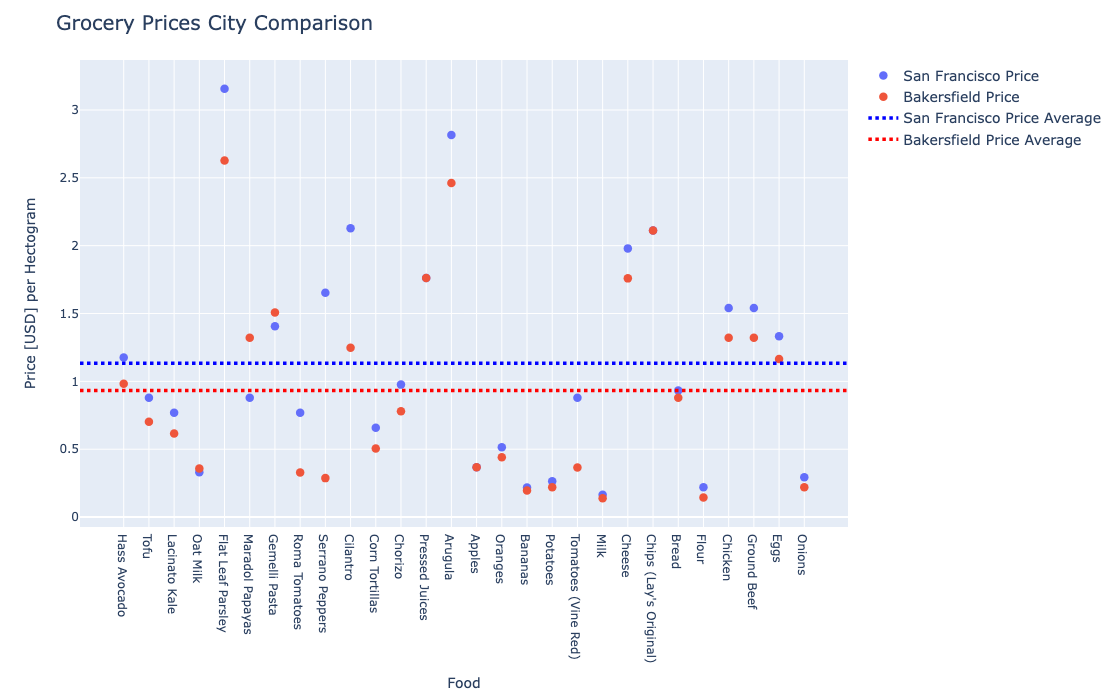

In [38]:
import plotly.graph_objects as go

SF_price_label = 'San Francisco Price'
BK_price_label = 'Bakersfield Price'

fig = px.scatter(SF, x='Food', y=[SF['FDC Price'], BK['FDC Price']], height=700, width=1000,
                 labels={'Food': 'Food'})
fig.update_traces(marker_size=8.5)
fig.for_each_trace(lambda t: t.update(name=SF_price_label) if t.name == SF['FDC Price'].name else t.update(name=BK_price_label))

# figure out how to add the legend values for the add_hline

# Add horizontal lines
fig.add_hline(y=np.mean(SF['FDC Price']), line_dash="dot", line_color="blue", line_width=3.5, name='San Francisco Price Average', showlegend=True)# annotation_fontsize = 12, font_color = 'red')

fig.add_hline(y=np.mean(BK['FDC Price']), line_dash="dot", line_color="red", line_width=3.5, name = 'Bakersfield Price Average', showlegend=True)

fig.update_layout(title = dict(text='Grocery Prices City Comparison', font=dict(size=20)),
                  yaxis_title='Price [USD] per Hectogram', showlegend=True, legend_title=None, 
                 legend=dict(font=dict(size= 14)))

fig.write_image('Grocery Prices City Comparison.png')

fig.show()

In [120]:
126187 - 69014

57173

In [121]:
126187/69014

1.8284261164401425

In [130]:
69014/126187

0.5469184622821686

In [39]:
# median household incomes
# SF Number Source: https://www.census.gov/quickfacts/fact/table/sanfranciscocitycalifornia/PST045222
# Bakersfield Number Source: https://www.census.gov/quickfacts/fact/table/bakersfieldcitycalifornia/INC110222



SF_HH_ann = 136689
BK_HH_ann = 73827

SF_HH_day = SF_HH_ann/365
BK_HH_day = BK_HH_ann/365

SF['Price as % of Daily Income'] = (SF['FDC Price']/SF_HH_day)*100
BK['Price as % of Daily Income'] = (BK['FDC Price']/BK_HH_day)*100

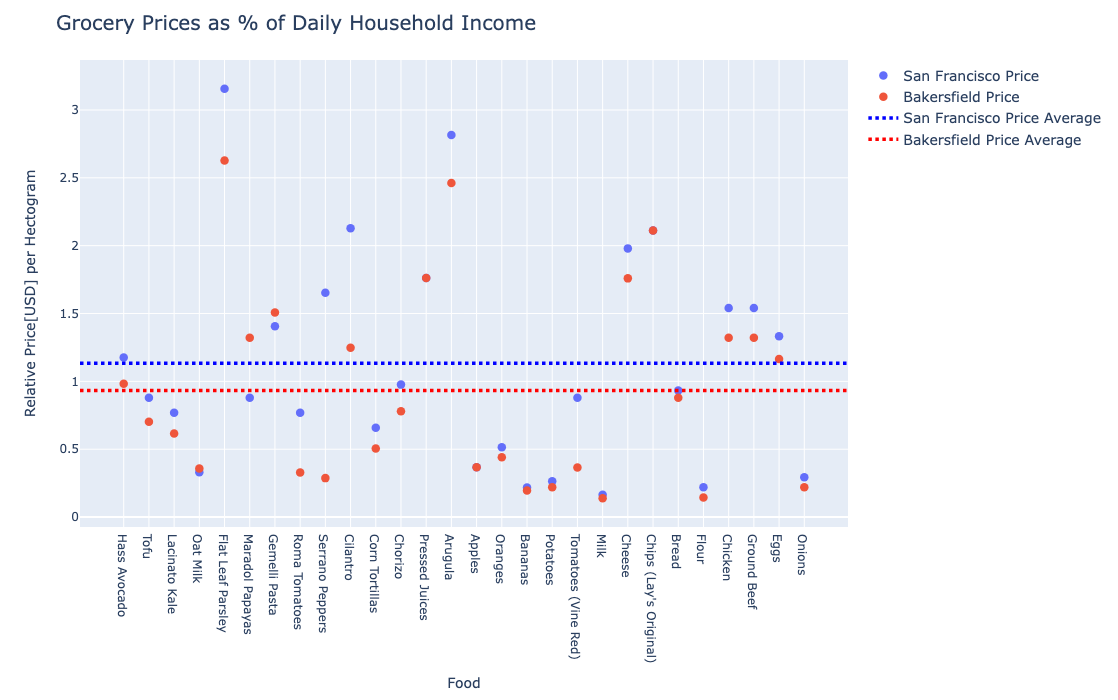

In [40]:
fig.update_traces(marker_size=8.5)
fig.update_layout(title = dict(text='Grocery Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14)))

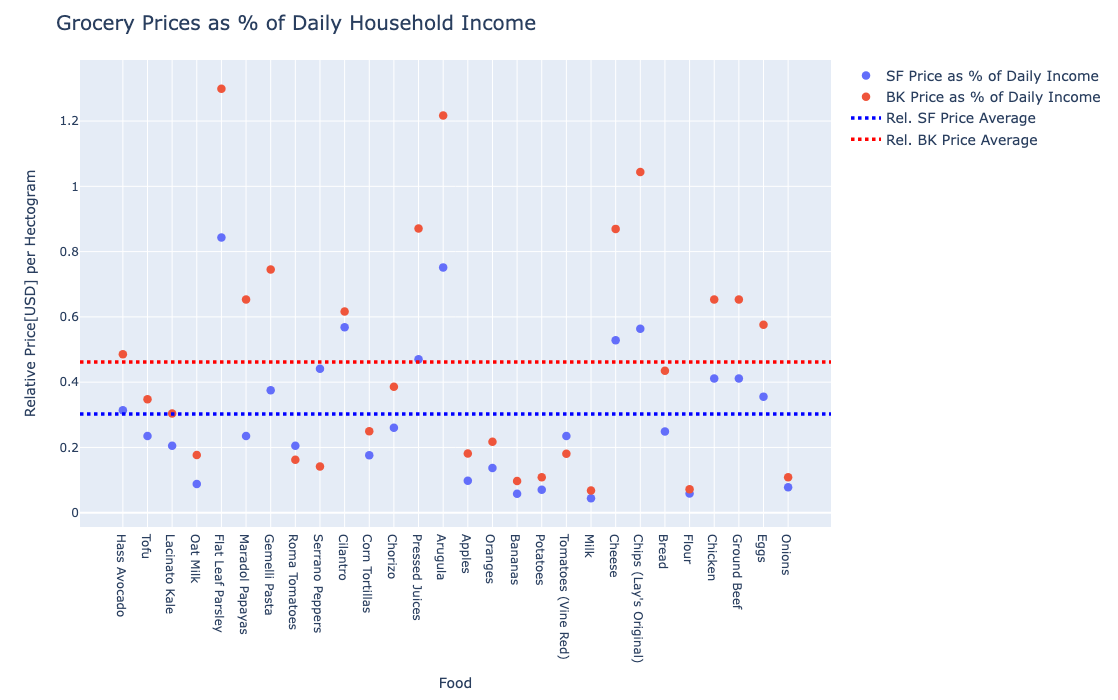

In [41]:
SF_price_label = 'SF Price as % of Daily Income'
BK_price_label = 'BK Price as % of Daily Income'

fig = px.scatter(SF, x='Food', y=[SF['Price as % of Daily Income'], BK['Price as % of Daily Income']], height=700, width=1000,
                 labels={'Food': 'Food'})
fig.for_each_trace(lambda t: t.update(name=SF_price_label) if t.name == SF['Price as % of Daily Income'].name else t.update(name=BK_price_label))
fig.update_traces(marker_size=8.5)

# Add horizontal lines
fig.add_hline(y=np.mean(SF['Price as % of Daily Income']), line_dash="dot", line_color="blue", line_width=3.5, name='Rel. SF Price Average', showlegend=True)
fig.add_hline(y=np.mean(BK['Price as % of Daily Income']), line_dash="dot", line_color="red", line_width=3.5, name = 'Rel. BK Price Average', showlegend=True)

fig.update_layout(title = dict(text='Grocery Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14)))
fig.write_image('RELATIVE Grocery Prices Comparison.png')
fig.show()

## With relative comparison: MORE EXPENSIVE FOR PEOPLE IN BAKERSFIELD !!!!!!

In [125]:
min_costs['SF Min. Cost as % of Daily Income'] = (min_costs['Minimum Cost Diet in San Francisco']/SF_HH_day)*100
min_costs['SF Rel. Cost @ 20th'] = (min_costs['Minimum Cost Diet in San Francisco']/SF_HH_day)*100


min_costs['BK Min. Cost as % of Daily Income'] = (min_costs['Minimum Cost Diet in Bakersfield']/BK_HH_day)*100
min_costs['BK Min. Cost as % of Daily Income'] = (min_costs['Minimum Cost Diet in Bakersfield']/BK_HH_day)*100


#SF95day, SF80day, SF60day, SF40day, SF20day 

min_costs['SF Rel. Min Cost @ 20th'] = min_costs['Minimum Cost Diet in San Francisco']/SF20day*100
min_costs['SF Rel. Min Cost @ 40th'] = min_costs['Minimum Cost Diet in San Francisco']/SF40day*100
min_costs['SF Rel. Min Cost @ 60th'] = min_costs['Minimum Cost Diet in San Francisco']/SF60day*100
min_costs['SF Rel. Min Cost @ 80th'] = min_costs['Minimum Cost Diet in San Francisco']/SF80day*100
min_costs['SF Rel. Min Cost @ 95th'] = min_costs['Minimum Cost Diet in San Francisco']/SF95day*100

#BK95day, BK80day, BK60day, BK40day, BK20day 
min_costs['BK Rel. Min Cost @ 20th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK20day*100
min_costs['BK Rel. Min Cost @ 40th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK40day*100
min_costs['BK Rel. Min Cost @ 60th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK60day*100
min_costs['BK Rel. Min Cost @ 80th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK80day*100
min_costs['BK Rel. Min Cost @ 95th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK95day*100


min_costs['SF Rel. Min Cost @ 20th'] = min_costs['Minimum Cost Diet in San Francisco']/SF20day*100
min_costs['SF Rel. Min Cost @ 40th'] = min_costs['Minimum Cost Diet in San Francisco']/SF40day*100
min_costs['SF Rel. Min Cost @ 60th'] = min_costs['Minimum Cost Diet in San Francisco']/SF60day*100
min_costs['SF Rel. Min Cost @ 80th'] = min_costs['Minimum Cost Diet in San Francisco']/SF80day*100
min_costs['SF Rel. Min Cost @ 95th'] = min_costs['Minimum Cost Diet in San Francisco']/SF95day*100


min_costs['BK Rel. Min Cost @ 20th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK20day*100
min_costs['BK Rel. Min Cost @ 40th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK40day*100
min_costs['BK Rel. Min Cost @ 60th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK60day*100
min_costs['BK Rel. Min Cost @ 80th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK80day*100
min_costs['BK Rel. Min Cost @ 95th'] = min_costs['Minimum Cost Diet in Bakersfield']/BK95day*100



#min_costs_F = min_costs[min_costs['Group'] == 'C 1-3', 'F 4-8', 'F 9-13', 'F 14-18', 'F 19-30', 'F 31-50', 'F 51+']
#min_costs_M = min_costs[min_costs['Group'] == ['C 1-3', 'M 4-8', 'M 9-13', 'M 14-18', 'M 19-30', 'M 31-50', 'M 51+']]
F_groups = ['C 1-3', 'F 4-8', 'F 9-13', 'F 14-18', 'F 19-30', 'F 31-50', 'F 51+']
M_groups = ['C 1-3', 'M 4-8', 'M 9-13', 'M 14-18', 'M 19-30', 'M 31-50', 'M 51+']
min_costs_F = min_costs[min_costs['Group'].isin(F_groups)]
min_costs_M = min_costs[min_costs['Group'].isin(M_groups)]
min_costs_F

Group  Minimum Cost Diet in San Francisco  \
0     C 1-3                           12.074666   
1     F 4-8                           15.738604   
3    F 9-13                           24.209436   
5   F 14-18                           30.844064   
7   F 19-30                           29.033870   
9   F 31-50                           29.144226   
11    F 51+                           29.392049   

    Minimum Cost Diet in Bakersfield  SF Min. Cost as % of Daily Income  \
0                           5.988562                           3.224292   
1                           8.106750                           4.202672   
3                          12.511033                           6.464634   
5                          14.051735                           8.236276   
7                          13.170591                           7.752901   
9                          13.064840                           7.782369   
11                         13.175645                           7.848545   

    BK Min. Cost as % of Daily Income  SF Rel. Cost @ 20th  \
0                            2.960740             3.224292   
1                            4.007969             4.202672   
3                            6.185443             6.464634   
5                            6.947165             8.236276   
7                            6.511528             7.752901   
9                            6.459245             7.782369   
11                           6.514027             7.848545   

    SF Rel. Min Cost @ 20th  SF Rel. Min Cost @ 40th  SF Rel. Min Cost @ 60th  \
0                 16.631144                 6.749239                 3.903679   
1                 21.677700                 8.797229                 5.088211   
3                 33.345072                13.532073                 7.826788   
5                 42.483334                17.240557                 9.971730   
7                 39.990047                16.228733                 9.386503   
9                 40.142047                16.290417                 9.422181   
11                40.483388                16.428940                 9.502301   

    SF Rel. Min Cost @ 80th  SF Rel. Min Cost @ 95th  BK Rel. Min Cost @ 20th  \
0                  2.311092                 0.713379                 9.261971   
1                  3.012370                 0.929846                12.537981   
3                  4.633689                 1.430308                19.349691   
5                  5.903557                 1.822286                21.732557   
7                  5.557086                 1.715339                20.369770   
9                  5.578208                 1.721859                20.206214   
11                 5.625641                 1.736500                20.377587   

    BK Rel. Min Cost @ 40th  BK Rel. Min Cost @ 60th  BK Rel. Min Cost @ 80th  \
0                  4.741486                 2.998389                 1.942956   
1                  6.418576                 4.058935                 2.630190   
3                  9.905699                 6.264098                 4.059135   
5                 11.125561                 7.035505                 4.559007   
7                 10.427908                 6.594329                 4.273125   
9                 10.344179                 6.541381                 4.238815   
11                10.431910                 6.596859                 4.274765   

    BK Rel. Min Cost @ 95th  
0                  1.120361  
1                  1.516639  
3                  2.340608  
5                  2.628849  
7                  2.464001  
9                  2.444217  
11                 2.464946

In [133]:
min_costs_F['SF/BK Min Cost Ratio'] = min_costs_F['Minimum Cost Diet in San Francisco']/ min_costs_F['Minimum Cost Diet in Bakersfield']
min_costs_F['SF/BK REL Min Cost Ratio'] = min_costs_F['SF Min. Cost as % of Daily Income']/ min_costs_F['BK Min. Cost as % of Daily Income']

min_costs_M['SF/BK Min Cost Ratio'] = min_costs_M['Minimum Cost Diet in San Francisco']/ min_costs_M['Minimum Cost Diet in Bakersfield']
min_costs_M['SF/BK REL Min Cost Ratio'] = min_costs_M['SF Min. Cost as % of Daily Income']/ min_costs_M['BK Min. Cost as % of Daily Income']

print('Average Absolute Minimum Cost Ratio, FEMALE = ' + str(min_costs_F['SF/BK Min Cost Ratio'].mean))
print('Average Relative Minimum Cost Ratio, FEMALE = ' + str(min_costs_F['SF/BK REL Min Cost Ratio'].mean))

print('Average Absolute Minimum Cost Ratio, MALE = ' + str(min_costs_M['SF/BK Min Cost Ratio'].mean))
print('Average Relative Minimum Cost Ratio, MALE = ' + str(min_costs_M['SF/BK REL Min Cost Ratio'].mean))

Average Absolute Minimum Cost Ratio, FEMALE = <bound method Series.mean of 0     2.016288
1     1.941420
3     1.935047
5     2.195036
7     2.204447
9     2.230737
11    2.230786
Name: SF/BK Min Cost Ratio, dtype: float64>
Average Relative Minimum Cost Ratio, FEMALE = <bound method Series.mean of 0     1.089016
1     1.048579
3     1.045137
5     1.185559
7     1.190642
9     1.204842
11    1.204868
Name: SF/BK REL Min Cost Ratio, dtype: float64>
Average Absolute Minimum Cost Ratio, MALE = <bound method Series.mean of 0     2.016288
2     1.931885
4     1.928003
6     1.686448
8     1.836770
10    1.832937
12    1.832937
Name: SF/BK Min Cost Ratio, dtype: float64>
Average Relative Minimum Cost Ratio, MALE = <bound method Series.mean of 0     1.089016
2     1.043429
4     1.041333
6     0.910866
8     0.992056
10    0.989986
12    0.989986
Name: SF/BK REL Min Cost Ratio, dtype: float64>


/tmp/ipykernel_152/542640190.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/542640190.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/542640190.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/542640

In [136]:
min_costs_M

Group  Minimum Cost Diet in San Francisco  \
0     C 1-3                           12.074666   
2     M 4-8                           15.851948   
4    M 9-13                           24.278548   
6   M 14-18                           33.482752   
8   M 19-30                           32.998152   
10  M 31-50                           33.223881   
12    M 51+                           33.223881   

    Minimum Cost Diet in Bakersfield  SF Min. Cost as % of Daily Income  \
0                           5.988562                           3.224292   
2                           8.205432                           4.232938   
4                          12.592585                           6.483089   
6                          19.854011                           8.940884   
8                          17.965318                           8.811481   
10                         18.126035                           8.871758   
12                         18.126035                           8.871758   

    BK Min. Cost as % of Daily Income  SF Rel. Cost @ 20th  \
0                            2.960740             3.224292   
2                            4.056758             4.232938   
4                            6.225762             6.483089   
6                            9.815804             8.940884   
8                            8.882037             8.811481   
10                           8.961495             8.871758   
12                           8.961495             8.871758   

    SF Rel. Min Cost @ 20th  SF Rel. Min Cost @ 40th  SF Rel. Min Cost @ 60th  \
0                 16.631144                 6.749239                 3.903679   
2                 21.833816                 8.860584                 5.124855   
4                 33.440264                13.570704                 7.849132   
6                 46.117753                18.715474                10.824805   
8                 45.450285                18.444603                10.668136   
10                45.761195                18.570776                10.741113   
12                45.761195                18.570776                10.741113   

    SF Rel. Min Cost @ 80th  SF Rel. Min Cost @ 95th  BK Rel. Min Cost @ 20th  \
0                  2.311092                 0.713379                 9.261971   
2                  3.034065                 0.936543                12.690605   
4                  4.646917                 1.434391                19.475820   
6                  6.408602                 1.978181                30.706415   
8                  6.315850                 1.949551                27.785344   
10                 6.359054                 1.962887                28.033910   
12                 6.359054                 1.962887                28.033910   

    BK Rel. Min Cost @ 40th  BK Rel. Min Cost @ 60th  BK Rel. Min Cost @ 80th  \
0                  4.741486                 2.998389                 1.942956   
2                  6.496709                 4.108344                 2.662207   
4                  9.970268                 6.304929                 4.085594   
6                 15.719553                 9.940623                 6.441523   
8                 14.224167                 8.994981                 5.828748   
10                14.351416                 9.075450                 5.880891   
12                14.351416                 9.075450                 5.880891   

    BK Rel. Min Cost @ 95th  SF/BK Min Cost Ratio  SF/BK REL Min Cost Ratio  
0                  1.120361              2.016288                  1.089016  
2                  1.535101              1.931885                  1.043429  
4                  2.355865              1.928003                  1.041333  
6                  3.714359              1.686448                  0.910866  
8                  3.361015              1.836770                  0.992056  
10                 3.391083              1.832937                  0.989986  
12    

In [135]:
min_costs_F

Group  Minimum Cost Diet in San Francisco  \
0     C 1-3                           12.074666   
1     F 4-8                           15.738604   
3    F 9-13                           24.209436   
5   F 14-18                           30.844064   
7   F 19-30                           29.033870   
9   F 31-50                           29.144226   
11    F 51+                           29.392049   

    Minimum Cost Diet in Bakersfield  SF Min. Cost as % of Daily Income  \
0                           5.988562                           3.224292   
1                           8.106750                           4.202672   
3                          12.511033                           6.464634   
5                          14.051735                           8.236276   
7                          13.170591                           7.752901   
9                          13.064840                           7.782369   
11                         13.175645                           7.848545   

    BK Min. Cost as % of Daily Income  SF Rel. Cost @ 20th  \
0                            2.960740             3.224292   
1                            4.007969             4.202672   
3                            6.185443             6.464634   
5                            6.947165             8.236276   
7                            6.511528             7.752901   
9                            6.459245             7.782369   
11                           6.514027             7.848545   

    SF Rel. Min Cost @ 20th  SF Rel. Min Cost @ 40th  SF Rel. Min Cost @ 60th  \
0                 16.631144                 6.749239                 3.903679   
1                 21.677700                 8.797229                 5.088211   
3                 33.345072                13.532073                 7.826788   
5                 42.483334                17.240557                 9.971730   
7                 39.990047                16.228733                 9.386503   
9                 40.142047                16.290417                 9.422181   
11                40.483388                16.428940                 9.502301   

    SF Rel. Min Cost @ 80th  SF Rel. Min Cost @ 95th  BK Rel. Min Cost @ 20th  \
0                  2.311092                 0.713379                 9.261971   
1                  3.012370                 0.929846                12.537981   
3                  4.633689                 1.430308                19.349691   
5                  5.903557                 1.822286                21.732557   
7                  5.557086                 1.715339                20.369770   
9                  5.578208                 1.721859                20.206214   
11                 5.625641                 1.736500                20.377587   

    BK Rel. Min Cost @ 40th  BK Rel. Min Cost @ 60th  BK Rel. Min Cost @ 80th  \
0                  4.741486                 2.998389                 1.942956   
1                  6.418576                 4.058935                 2.630190   
3                  9.905699                 6.264098                 4.059135   
5                 11.125561                 7.035505                 4.559007   
7                 10.427908                 6.594329                 4.273125   
9                 10.344179                 6.541381                 4.238815   
11                10.431910                 6.596859                 4.274765   

    BK Rel. Min Cost @ 95th  SF/BK Min Cost Ratio  SF/BK REL Min Cost Ratio  
0                  1.120361              2.016288                  1.089016  
1                  1.516639              1.941420                  1.048579  
3                  2.340608              1.935047                  1.045137  
5                  2.628849              2.195036                  1.185559  
7                  2.464001              2.204447                  1.190642  
9                  2.444217              2.230737                  1.204842  
11    

In [131]:
min_costs_M['SF/BK Min Cost Ratio'] = min_costs_M['Minimum Cost Diet in San Francisco']/ min_costs_M['Minimum Cost Diet in Bakersfield']
min_costs_M['SF/BK REL Min Cost Ratio'] = min_costs_M['SF Min. Cost as % of Daily Income']/ min_costs_M['BK Min. Cost as % of Daily Income']

/tmp/ipykernel_152/1499233580.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/1499233580.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [129]:
print('Average Absolute Minimum Cost Ratio = ' + str(min_costs_F['SF/BK Min Cost Ratio'].mean))
print('Average Relative Minimum Cost Ratio = ' + str(min_costs_F['SF/BK REL Min Cost Ratio'].mean))

Average Absolute Minimum Cost Ratio = <bound method Series.mean of 0     2.016288
1     1.941420
3     1.935047
5     2.195036
7     2.204447
9     2.230737
11    2.230786
Name: SF/BK Min Cost Ratio, dtype: float64>
Average Relative Minimum Cost Ratio = <bound method Series.mean of 0     1.089016
1     1.048579
3     1.045137
5     1.185559
7     1.190642
9     1.204842
11    1.204868
Name: SF/BK REL Min Cost Ratio, dtype: float64>


In [70]:
min_costs_F_plotting = min_costs_F.drop(columns=['Minimum Cost Diet in San Francisco', 'Minimum Cost Diet in Bakersfield', 'SF Min. Cost as % of Daily Income',
                                                 'BK Min. Cost as % of Daily Income', 'BK Min. Cost as % of Daily Income'])
min_costs_F_plotting = min_costs_F_plotting.set_index('Group', inplace=False)

In [100]:
min_costs_M_plotting = min_costs_M.drop(columns=['Minimum Cost Diet in San Francisco', 'Minimum Cost Diet in Bakersfield', 'SF Min. Cost as % of Daily Income',
                                                 'BK Min. Cost as % of Daily Income', 'BK Min. Cost as % of Daily Income'])
min_costs_M_plotting = min_costs_M_plotting.set_index('Group', inplace=False)

In [ ]:
fig = px.line(min_costs_F_plotting, x=min_costs_F_plotting.index, y=['SF Rel. Min Cost @ 20th', 'SF Rel. Min Cost @ 40th', 
                                                                     'SF Rel. Min Cost @ 60th', 'SF Rel. Min Cost @ 80th', 
                                                                     'SF Rel. Min Cost @ 95th'], width = 700, height=600)
#fig.a_layout(
fig.update_layout(title = dict(text = 'SF FEMALE: Min. Cost Diets as % of Daily Income Percentiles', 
                               font=dict(size=20)), yaxis_title='Price per Hectogram / Daily Income', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 9), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

In [ ]:
fig = px.line(min_costs_F_plotting, x=min_costs_F_plotting.index, y=['BK Rel. Min Cost @ 20th', 'BK Rel. Min Cost @ 40th', 
                                                                     'BK Rel. Min Cost @ 60th', 'BK Rel. Min Cost @ 80th', 
                                                                     'BK Rel. Min Cost @ 95th'], width = 800, height=600)
#fig.a_layout(
fig.update_layout(title = dict(text = 'Bakersfield FEMALE: Min. Cost Diets as % of Daily Income Percentiles', 
                               font=dict(size=20)), yaxis_title='Price per Hectogram / Daily Income', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 9), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

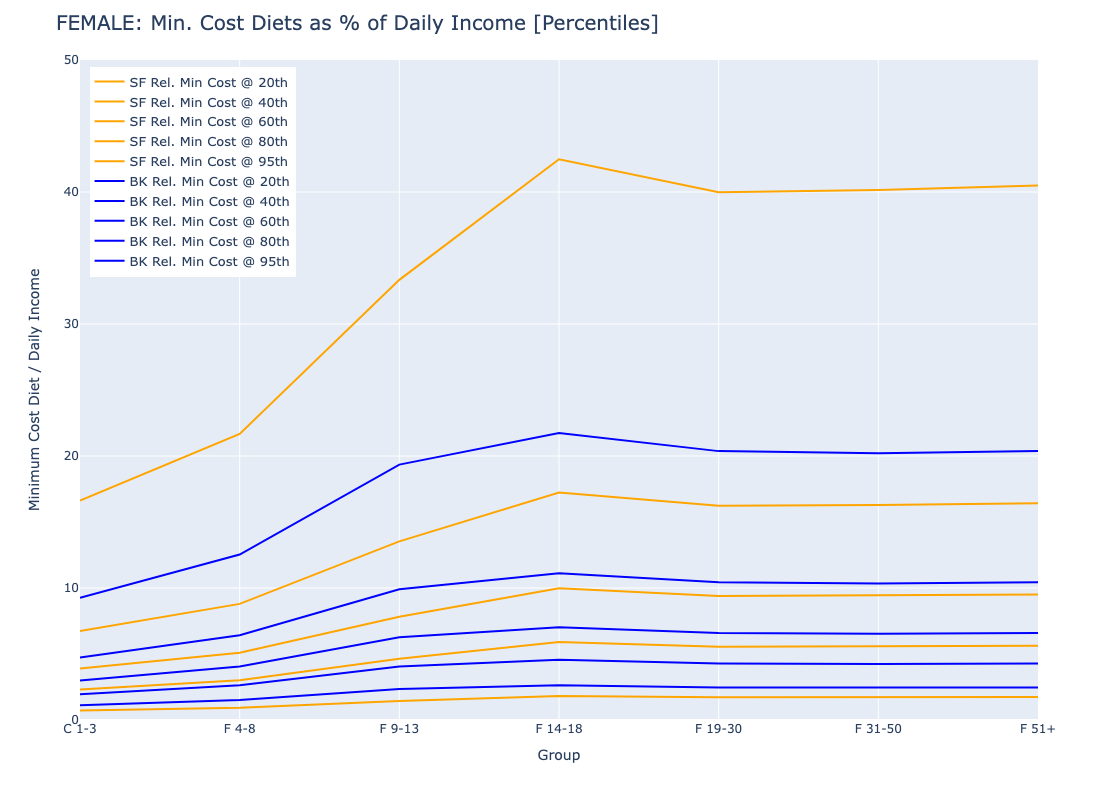

In [116]:
fig = px.line(min_costs_F_plotting, x=min_costs_F_plotting.index, y=['SF Rel. Min Cost @ 20th', 'SF Rel. Min Cost @ 40th', 
                                                                     'SF Rel. Min Cost @ 60th', 'SF Rel. Min Cost @ 80th', 
                                                                     'SF Rel. Min Cost @ 95th', 'BK Rel. Min Cost @ 20th', 
                                                                     'BK Rel. Min Cost @ 40th', 'BK Rel. Min Cost @ 60th', 
                                                                     'BK Rel. Min Cost @ 80th', 'BK Rel. Min Cost @ 95th'], 
              width = 900, height=800, color_discrete_sequence=['orange', 'orange', 'orange', 'orange', 'orange', 'blue','blue','blue','blue','blue'])
                                                                    
#fig.a_layout(
fig.update_layout(title = dict(text = 'FEMALE: Min. Cost Diets as % of Daily Income [Percentiles]', 
                               font=dict(size=20)), yaxis_title='Minimum Cost Diet / Daily Income', 
                  showlegend=True, legend_title=None, yaxis=dict(range=[0, 50]), legend=dict(font=dict(size= 13), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

#note: cost 


fig.write_image('female_rel_min_costs.png')
fig

#color_discrete_sequence=['blue', 'blue', 'red', 'red'])

In [119]:
fig = px.line(min_costs_M_plotting, x=min_costs_M_plotting.index, y=['SF Rel. Min Cost @ 20th', 'SF Rel. Min Cost @ 40th', 
                                                                     'SF Rel. Min Cost @ 60th', 'SF Rel. Min Cost @ 80th', 
                                                                     'SF Rel. Min Cost @ 95th', 'BK Rel. Min Cost @ 20th', 
                                                                     'BK Rel. Min Cost @ 40th', 'BK Rel. Min Cost @ 60th', 
                                                                     'BK Rel. Min Cost @ 80th', 'BK Rel. Min Cost @ 95th'], 
              width = 900, height=800, color_discrete_sequence=['orange', 'orange', 'orange', 'orange', 'orange', 'blue','blue','blue','blue','blue'])
                                                                    
#fig.a_layout(
fig.update_layout(title = dict(text = 'MALE: Min. Cost Diets as % of Daily Income [Percentiles]', 
                               font=dict(size=20)), yaxis_title='Minimum Cost Diet / Daily Income', 
                  showlegend=True, legend_title=None, yaxis=dict(range=[0, 50]), legend=dict(font=dict(size= 13), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.write_image('male_rel_min_costs.png')

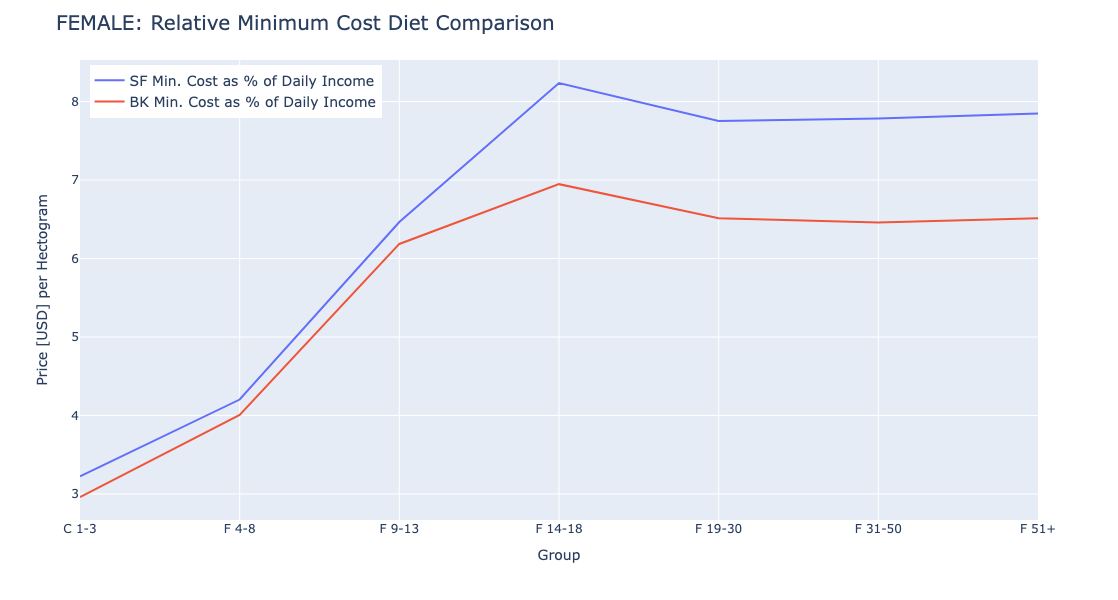

In [44]:
fig = px.line(min_costs_F, x='Group', y = ['SF Min. Cost as % of Daily Income', 'BK Min. Cost as % of Daily Income'],  height=600, width=1000)
fig.update_layout(title = dict(text = 'FEMALE: Relative Minimum Cost Diet Comparison', font=dict(size=20)), yaxis_title='Price [USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.write_image('Female: Rel. Min. Cost Diets.png')
fig.show()

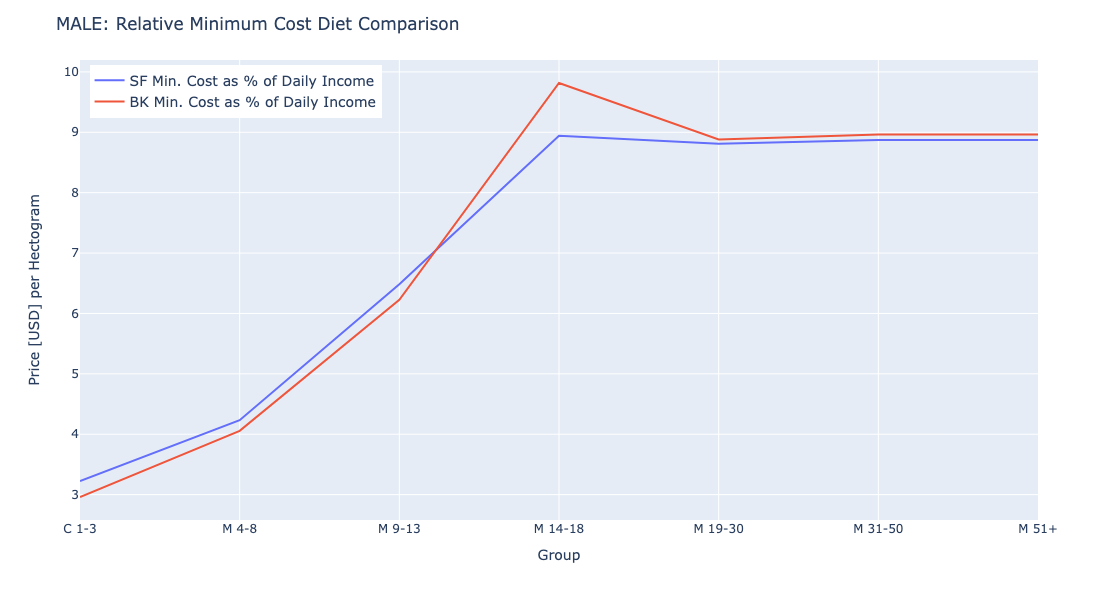

In [45]:
fig = px.line(min_costs_M, x='Group', y = ['SF Min. Cost as % of Daily Income', 'BK Min. Cost as % of Daily Income'],  height=600, width=1000)
fig.update_layout(title = 'MALE: Relative Minimum Cost Diet Comparison', yaxis_title='Price [USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14), 
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.write_image('Male: Rel. Min. Cost Diets.png')
fig.show()

More Plots to Make: 
- Effects of Price Changes on Subsistence Diet Cost !!!!!! [B] deliverable
- Scatter Price plots relative to income bracket (median HH income)
- Pi chart with percentage of the population in each income bracket
- maybe look at the rent prices in the area of the Safeway comparatively 


In [46]:
min_costs_F['San Francisco, Bottom 20%'] = (min_costs_F['Minimum Cost Diet in San Francisco']/SF20day*100)
min_costs_F['Bakersfield, Bottom 20%'] = (min_costs_F['Minimum Cost Diet in Bakersfield']/BK20day*100)

min_costs_M['San Francisco, Bottom 20%'] = (min_costs_M['Minimum Cost Diet in San Francisco']/SF20day*100)
min_costs_M['Bakersfield, Bottom 20%'] = (min_costs_M['Minimum Cost Diet in Bakersfield']/BK20day*100)

NameError: name 'SF20day' is not defined

In [56]:
#min_costs['SF Min. Cost as % of Daily Income'] = (min_costs['Minimum Cost Diet in San Francisco']/SF_HH_day)*100
#min_costs['BK Min. Cost as % of Daily Income'] = (min_costs['Minimum Cost Diet in Bakersfield']/BK_HH_day)*100

SF['FDC Price'] = SF['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
SF['FDC Price'] = SF['FDC Price'].apply(lambda x: round(float(x), 3))

BK['FDC Price'] = BK['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
BK['FDC Price'] = BK['FDC Price'].apply(lambda x: round(float(x), 3))


SF['Price as % of Daily Income'] = (SF['FDC Price']/SF_HH_day)*100
BK['Price as % of Daily Income'] = (BK['FDC Price']/BK_HH_day)*100

# income percentiles $ for BK: 
BK_95th = 195100
BK_80th = 112500
BK_60th = 72900
BK_40th = 46100
BK_20th = 23600

BK95day, BK80day, BK60day, BK40day, BK20day = BK_95th/365, BK_80th/365, BK_60th/365, BK_40th/365, BK_20th/365

BK['Price % 95th'] = (BK['FDC Price']/BK95day)*100
BK['Price % 80th'] = (BK['FDC Price']/BK80day)*100
BK['Price % 60th'] = (BK['FDC Price']/BK60day)*100
BK['Price % 40th'] = (BK['FDC Price']/BK40day)*100
BK['Price % 20th'] = (BK['FDC Price']/BK20day)*100



# income percentiles $ for SF: 
SF_95th = 617800
SF_80th = 190700
SF_60th = 112900
SF_40th = 65300
SF_20th = 26500

SF95day, SF80day, SF60day, SF40day, SF20day = SF_95th/365, SF_80th/365, SF_60th/365, SF_40th/365, SF_20th/365

SF['Price % 95th'] = (SF['FDC Price']/SF95day)*100
SF['Price % 80th'] = (SF['FDC Price']/SF80day)*100
SF['Price % 60th'] = (SF['FDC Price']/SF60day)*100
SF['Price % 40th'] = (SF['FDC Price']/SF40day)*100
SF['Price % 20th'] = (SF['FDC Price']/SF20day)*100

# SF for pie chart 
SF_under25 = 4.2 + 4.5 + 4.9
SF_25_50 = 4.2 + 5.2 
SF_50_100 = 8.4 + 8.6
SF_100_200 = 13.6 + 11.5
SF_over200 = 35

# BK for pie chart 

BK_under25 = 6.1 + 4.4 + 5.6
BK_25_50 = 7.9 + 10
BK_50_100 = 18.1 + 14.7
BK_100_200 = 16.2 + 7.7 
BK_over200 = 9.4


# sources: https://data.census.gov/table/ACSDP1Y2022.DP03?q=Bakersfield%20city,%20California%20economic
# sources: https://data.census.gov/table/ACSDP5Y2022.DP03?g=040XX00US06_160XX00US0667000&tid=ACSDP5Y2022.DP03
# sources: https://statisticalatlas.com/place/California/Bakersfield/Household-Income
# sources: https://statisticalatlas.com/place/California/San-Francisco/Household-Income

In [57]:
#SF95day, SF80day, SF60day, SF40day, SF20day 

min_costs_F['SF Rel. Min Cost @ 20th'] = min_costs_F['Minimum Cost Diet in San Francisco']/SF20day*100
min_costs_F['SF Rel. Min Cost @ 40th'] = min_costs_F['Minimum Cost Diet in San Francisco']/SF40day*100
min_costs_F['SF Rel. Min Cost @ 60th'] = min_costs_F['Minimum Cost Diet in San Francisco']/SF60day*100
min_costs_F['SF Rel. Min Cost @ 80th'] = min_costs_F['Minimum Cost Diet in San Francisco']/SF80day*100
min_costs_F['SF Rel. Min Cost @ 95th'] = min_costs_F['Minimum Cost Diet in San Francisco']/SF95day*100

#BK95day, BK80day, BK60day, BK40day, BK20day 
min_costs_F['BK Rel. Min Cost @ 20th'] = min_costs_F['Minimum Cost Diet in Bakersfield']/BK20day*100
min_costs_F['BK Rel. Min Cost @ 40th'] = min_costs_F['Minimum Cost Diet in Bakersfield']/BK40day*100
min_costs_F['BK Rel. Min Cost @ 60th'] = min_costs_F['Minimum Cost Diet in Bakersfield']/BK60day*100
min_costs_F['BK Rel. Min Cost @ 80th'] = min_costs_F['Minimum Cost Diet in Bakersfield']/BK80day*100
min_costs_F['BK Rel. Min Cost @ 95th'] = min_costs_F['Minimum Cost Diet in Bakersfield']/BK95day*100


min_costs_M['SF Rel. Min Cost @ 20th'] = min_costs_M['Minimum Cost Diet in San Francisco']/SF20day*100
min_costs_M['SF Rel. Min Cost @ 40th'] = min_costs_M['Minimum Cost Diet in San Francisco']/SF40day*100
min_costs_M['SF Rel. Min Cost @ 60th'] = min_costs_M['Minimum Cost Diet in San Francisco']/SF60day*100
min_costs_M['SF Rel. Min Cost @ 80th'] = min_costs_M['Minimum Cost Diet in San Francisco']/SF80day*100
min_costs_M['SF Rel. Min Cost @ 95th'] = min_costs_M['Minimum Cost Diet in San Francisco']/SF95day*100


min_costs_M['BK Rel. Min Cost @ 20th'] = min_costs_M['Minimum Cost Diet in Bakersfield']/BK20day*100
min_costs_M['BK Rel. Min Cost @ 40th'] = min_costs_M['Minimum Cost Diet in Bakersfield']/BK40day*100
min_costs_M['BK Rel. Min Cost @ 60th'] = min_costs_M['Minimum Cost Diet in Bakersfield']/BK60day*100
min_costs_M['BK Rel. Min Cost @ 80th'] = min_costs_M['Minimum Cost Diet in Bakersfield']/BK80day*100
min_costs_M['BK Rel. Min Cost @ 95th'] = min_costs_M['Minimum Cost Diet in Bakersfield']/BK95day*100


min_costs_F

/tmp/ipykernel_152/1218582748.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/1218582748.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/1218582748.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_152/121

Group  Minimum Cost Diet in San Francisco  \
0     C 1-3                           12.074666   
1     F 4-8                           15.738604   
3    F 9-13                           24.209436   
5   F 14-18                           30.844064   
7   F 19-30                           29.033870   
9   F 31-50                           29.144226   
11    F 51+                           29.392049   

    Minimum Cost Diet in Bakersfield  SF Min. Cost as % of Daily Income  \
0                           5.988562                           3.224292   
1                           8.106750                           4.202672   
3                          12.511033                           6.464634   
5                          14.051735                           8.236276   
7                          13.170591                           7.752901   
9                          13.064840                           7.782369   
11                         13.175645                           7.848545   

    BK Min. Cost as % of Daily Income  SF Rel. Min Cost @ 20th  \
0                            2.960740                16.631144   
1                            4.007969                21.677700   
3                            6.185443                33.345072   
5                            6.947165                42.483334   
7                            6.511528                39.990047   
9                            6.459245                40.142047   
11                           6.514027                40.483388   

    SF Rel. Min Cost @ 40th  SF Rel. Min Cost @ 60th  SF Rel. Min Cost @ 80th  \
0                  6.749239                 3.903679                 2.311092   
1                  8.797229                 5.088211                 3.012370   
3                 13.532073                 7.826788                 4.633689   
5                 17.240557                 9.971730                 5.903557   
7                 16.228733                 9.386503                 5.557086   
9                 16.290417                 9.422181                 5.578208   
11                16.428940                 9.502301                 5.625641   

    SF Rel. Min Cost @ 95th  BK Rel. Min Cost @ 20th  BK Rel. Min Cost @ 40th  \
0                  0.713379                 9.261971                 4.741486   
1                  0.929846                12.537981                 6.418576   
3                  1.430308                19.349691                 9.905699   
5                  1.822286                21.732557                11.125561   
7                  1.715339                20.369770                10.427908   
9                  1.721859                20.206214                10.344179   
11                 1.736500                20.377587                10.431910   

    BK Rel. Min Cost @ 60th  BK Rel. Min Cost @ 80th  BK Rel. Min Cost @ 95th  
0                  2.998389                 1.942956                 1.120361  
1                  4.058935                 2.630190                 1.516639  
3                  6.264098                 4.059135                 2.340608  
5                  7.035505                 4.559007                 2.628849  
7                  6.594329                 4.273125                 2.464001  
9                  6.541381                 4.238815                 2.444217  
11                 6.596859                 4.274765                 2.464946

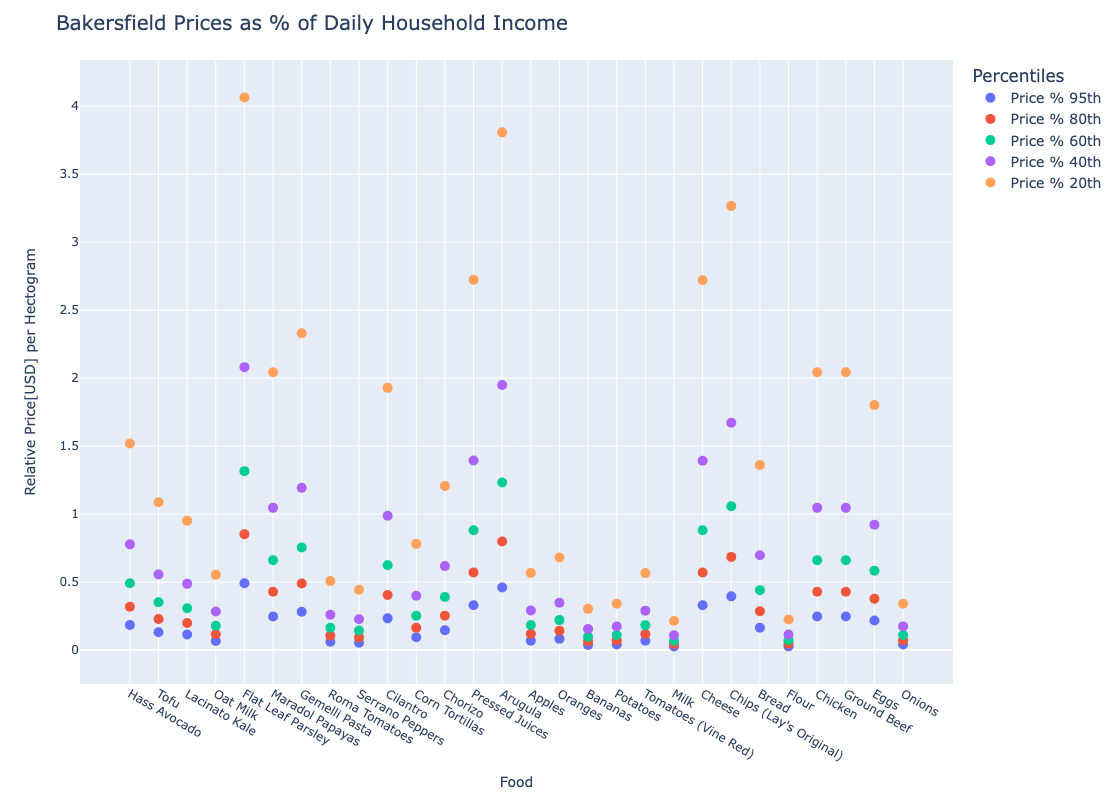

In [48]:
fig = px.scatter(BK, x='Food', y=[BK['Price % 95th'], BK['Price % 80th'], BK['Price % 60th'], 
                                 BK['Price % 40th'], BK['Price % 20th']], height=800, width=800,
                 labels={'Food': 'Food'})
fig.update_traces(marker_size=10)
fig.update_layout(title = dict(text='Bakersfield Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title='Percentiles', legend=dict(font=dict(size= 14)))
fig.write_image('Rel_BK_Prices_Quartiles.png')
fig

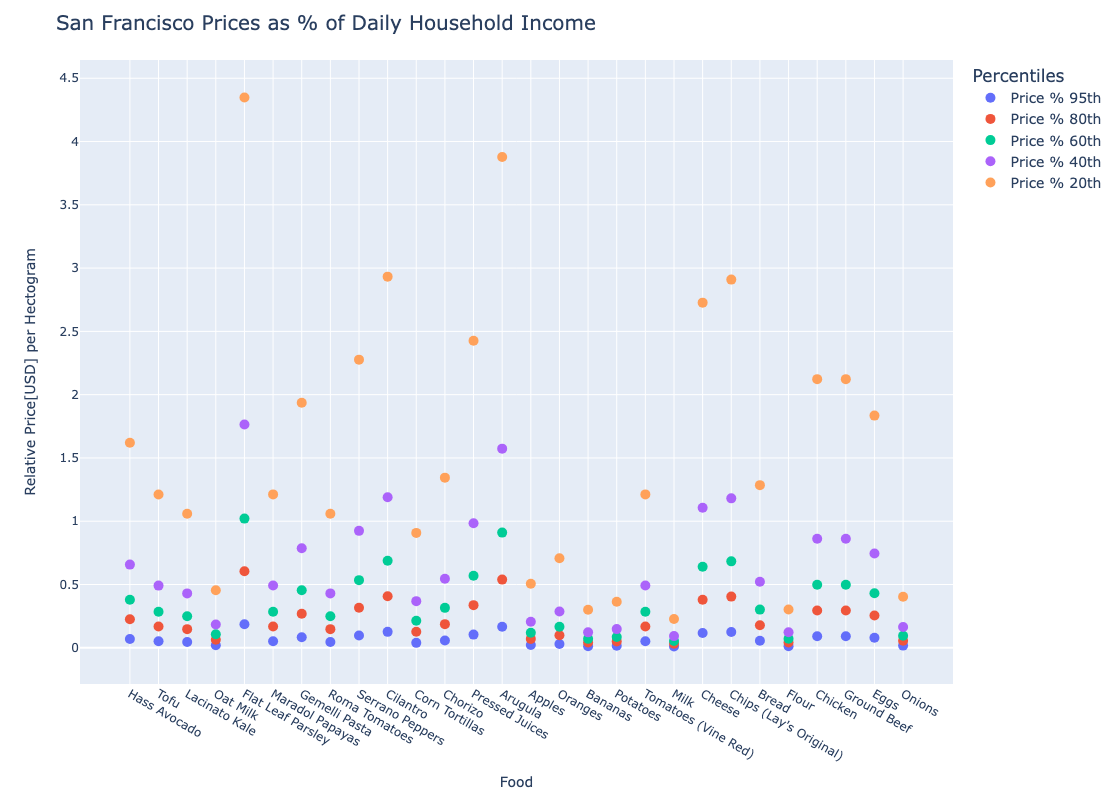

In [49]:
fig = px.scatter(SF, x='Food', y=[SF['Price % 95th'], SF['Price % 80th'], SF['Price % 60th'], 
                                 SF['Price % 40th'], SF['Price % 20th']], height=800, width=800,
                 labels={'Food': 'Food'})
fig.update_traces(marker_size=10)
fig.update_layout(title = dict(text='San Francisco Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title='Percentiles', legend=dict(font=dict(size= 14)))
fig.write_image('Rel_SF_Prices_Quartiles.png')
fig

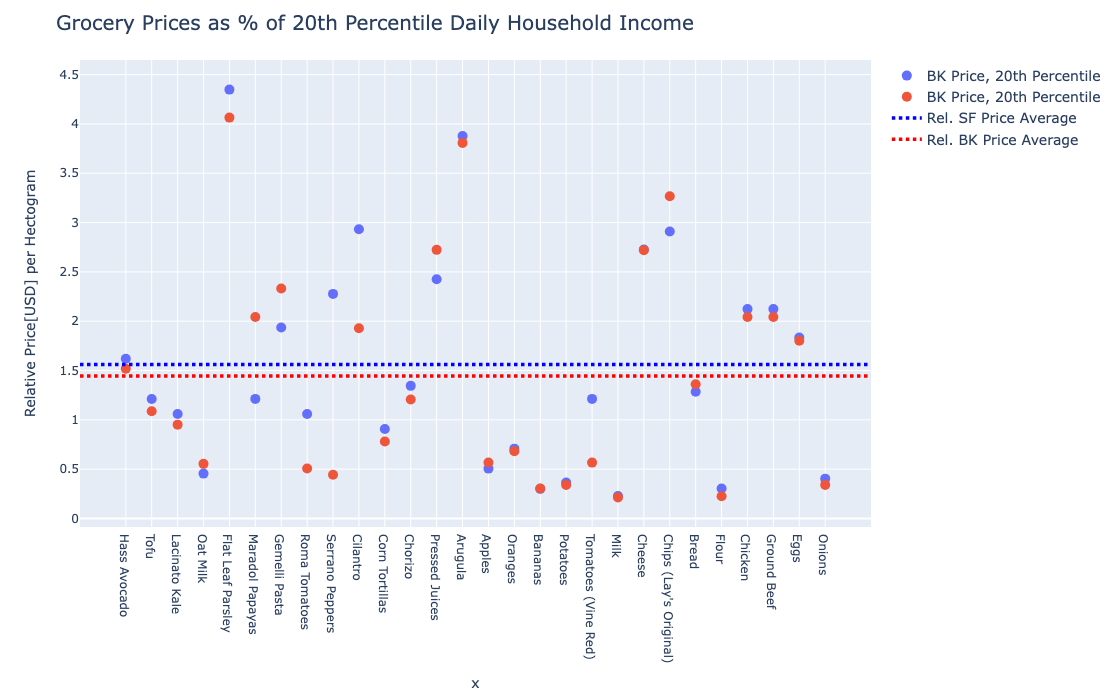

In [50]:
SF_price_label = 'SF Price, 20th Percentile'
BK_price_label = 'BK Price, 20th Percentile'

fig = px.scatter(x=SF['Food'], y=[SF['Price % 20th'], BK['Price % 20th']], height=700, width=1000, labels={'Food': 'Food'})
fig.for_each_trace(lambda t: t.update(name=SF_price_label) if t.name == SF['Price % 20th'].name else t.update(name=BK_price_label))
fig.update_traces(marker_size=10)

# Add horizontal lines
fig.add_hline(y=np.mean(SF['Price % 20th']), line_dash="dot", line_color="blue", line_width=3.5, name='Rel. SF Price Average', showlegend=True)
fig.add_hline(y=np.mean(BK['Price % 20th']), line_dash="dot", line_color="red", line_width=3.5, name = 'Rel. BK Price Average', showlegend=True)

fig.update_layout(title = dict(text='Grocery Prices as % of 20th Percentile Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14)))

fig.write_image('Price Comparison for 20th Percentile.png')

#fig = px.scatter(x=SF['Food'], y=[SF['Price % 20th'], BK['Price % 20th']], height=800, width=800,
                 #labels={'Food': 'Food'})
#fig.update_traces(marker_size=10)
#fig.update_layout(title = dict(text='San Francisco Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  #showlegend=True, legend_title='Percentiles', legend=dict(font=dict(size= 14)))
fig

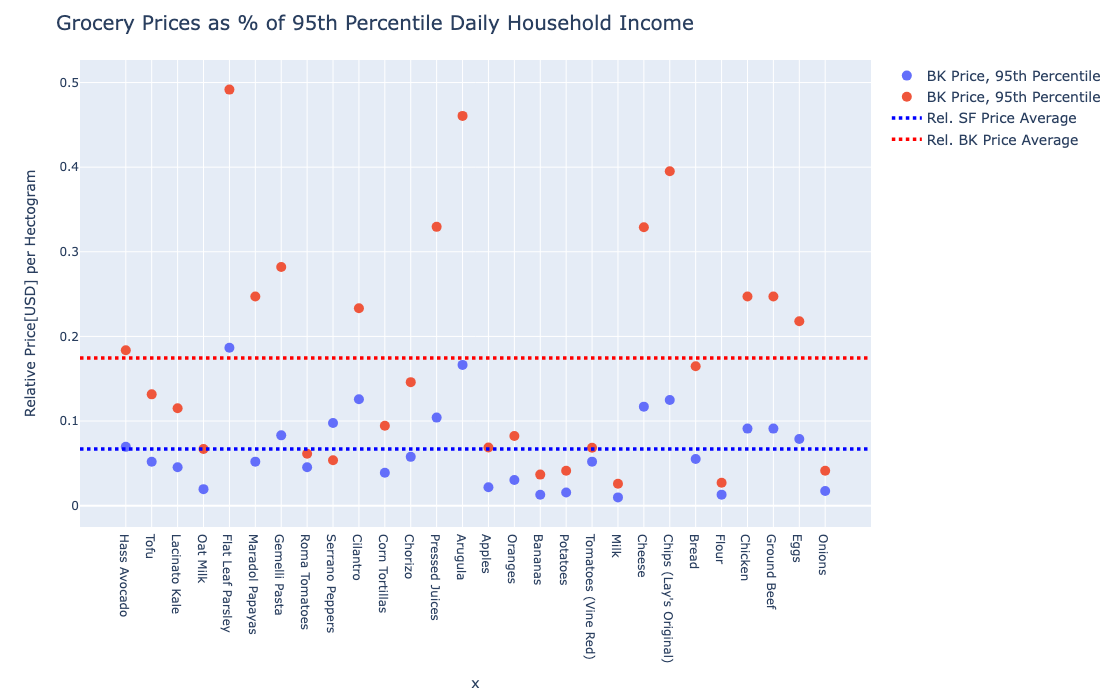

In [51]:
SF_price_label = 'SF Price, 95th Percentile'
BK_price_label = 'BK Price, 95th Percentile'

fig = px.scatter(x=SF['Food'], y=[SF['Price % 95th'], BK['Price % 95th']], height=700, width=1000, labels={'Food': 'Food'})
fig.for_each_trace(lambda t: t.update(name=SF_price_label) if t.name == SF['Price % 80th'].name else t.update(name=BK_price_label))
fig.update_traces(marker_size=10)

# Add horizontal lines
fig.add_hline(y=np.mean(SF['Price % 95th']), line_dash="dot", line_color="blue", line_width=3.5, name='Rel. SF Price Average', showlegend=True)
fig.add_hline(y=np.mean(BK['Price % 95th']), line_dash="dot", line_color="red", line_width=3.5, name = 'Rel. BK Price Average', showlegend=True)

fig.update_layout(title = dict(text='Grocery Prices as % of 95th Percentile Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  showlegend=True, legend_title=None, legend=dict(font=dict(size= 14)))

fig.write_image('Price Comparison for 95th Percentile.png')

#fig = px.scatter(x=SF['Food'], y=[SF['Price % 20th'], BK['Price % 20th']], height=800, width=800,
                 #labels={'Food': 'Food'})
#fig.update_traces(marker_size=10)
#fig.update_layout(title = dict(text='San Francisco Prices as % of Daily Household Income', font=dict(size=20)), yaxis_title='Relative Price[USD] per Hectogram', 
                  #showlegend=True, legend_title='Percentiles', legend=dict(font=dict(size= 14)))
fig

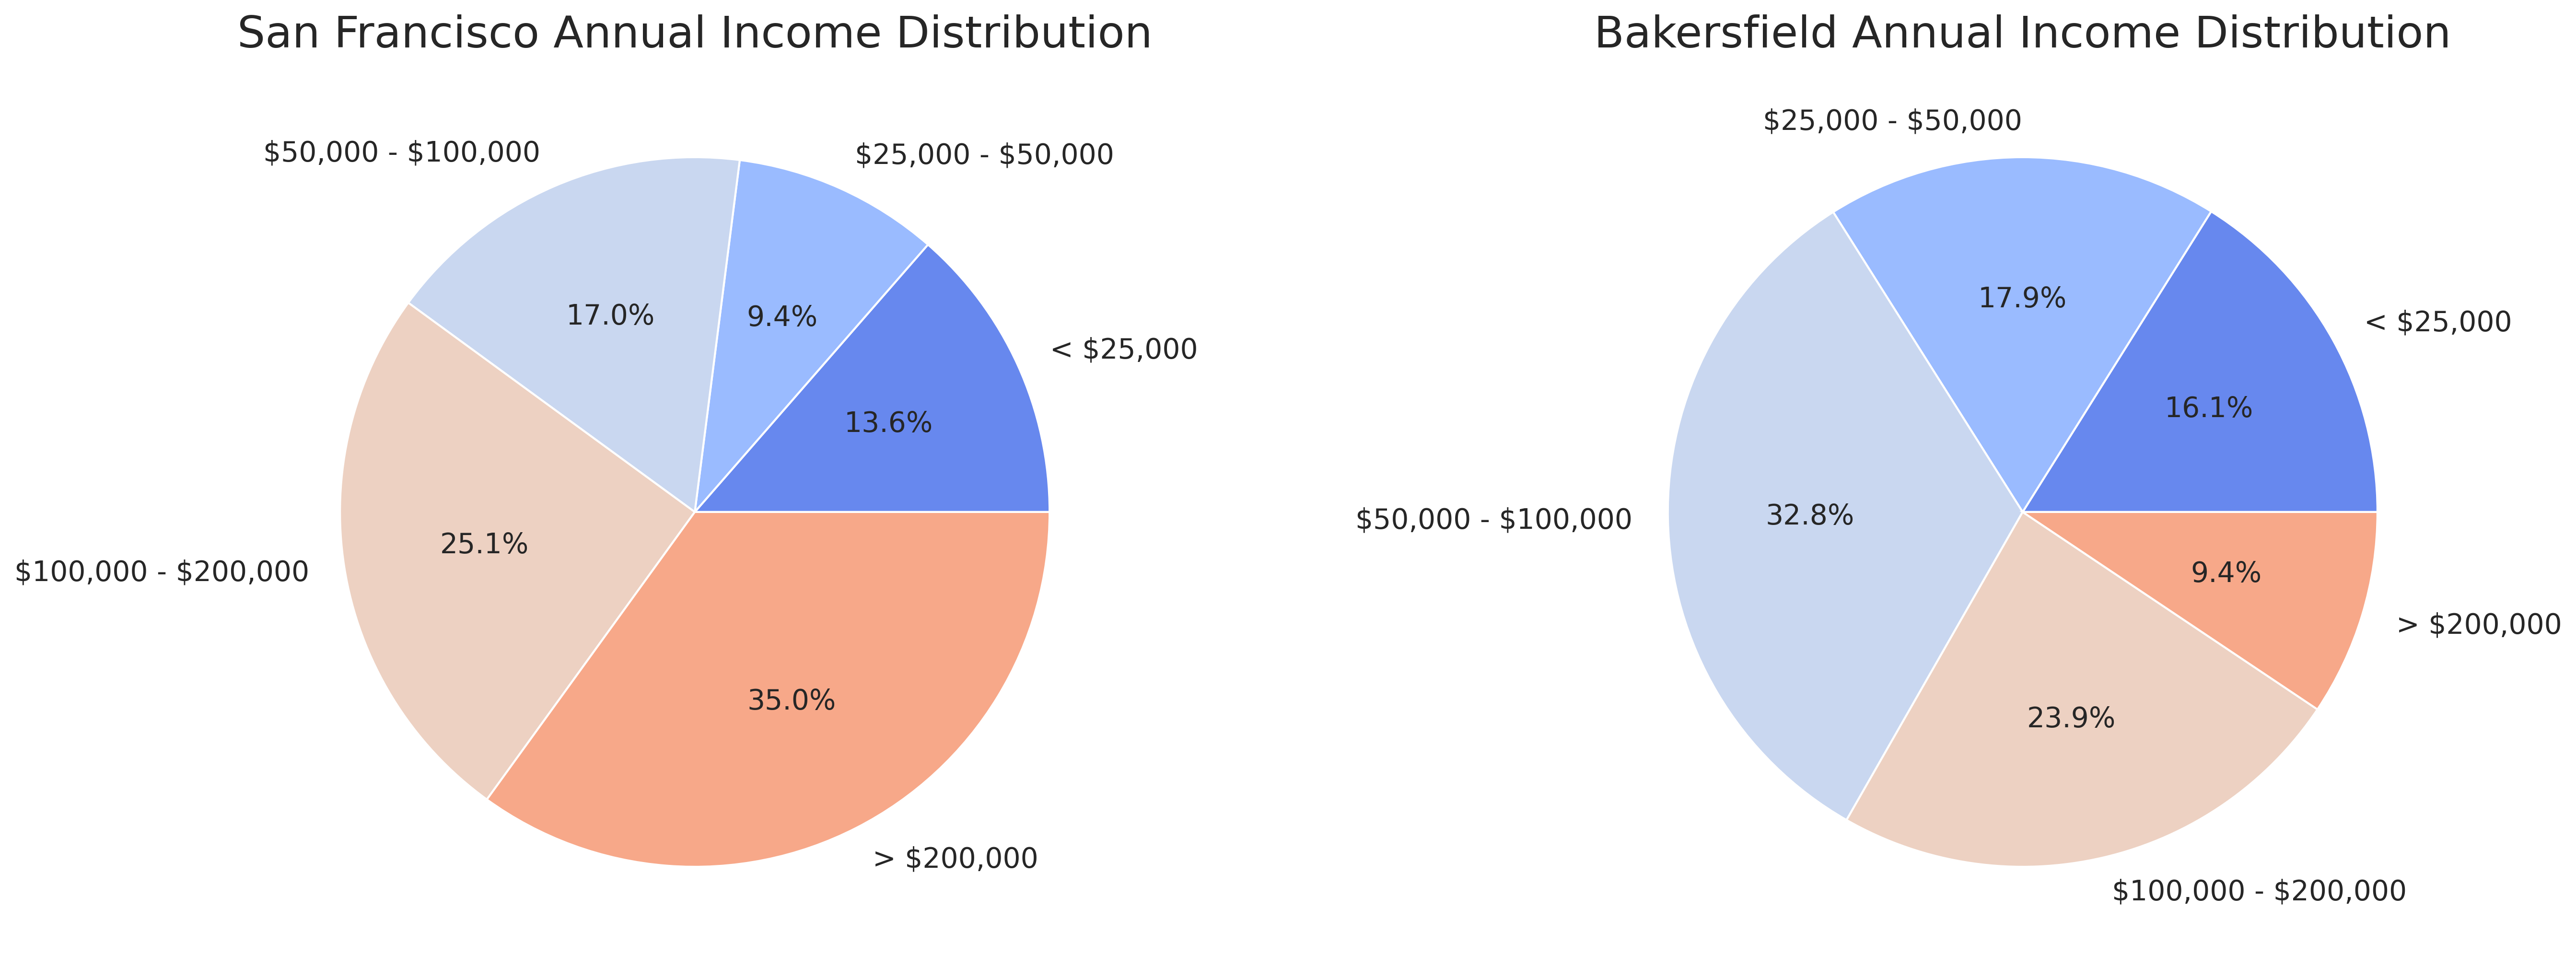

In [52]:
# make pie chart 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-v0_8'])
sns.set_theme(palette ='coolwarm')

# Sample data
labels = ['< $25,000', '$25,000 - \$50,000', '$50,000 - \$100,000', '$100,000 - \$200,000', '> $200,000']
sizes = [SF_under25, SF_25_50, SF_50_100, SF_100_200, SF_over200]  # Values corresponding to each label
sizes2 = [BK_under25, BK_25_50, BK_50_100, BK_100_200, BK_over200] 
# Create a pie chart
fig, ax = plt.subplots(1,2, figsize = (20,9), dpi=300)

ax[0].pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14}, labeldistance=1.1)
ax[0].axis('equal')
ax[0].set_title('San Francisco Annual Income Distribution', size=22)

ax[1].pie(sizes2, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})
ax[1].axis('equal')
ax[1].set_title('Bakersfield Annual Income Distribution', size=22)

plt.tight_layout(pad=7)
plt.savefig('income_pie_charts.png')
plt.show()

In [53]:
BK

Food                                             Region  \
0            Hass Avocado                     San Fracisco, CA: Popular Items   
1                     Tofu                                                NaN   
2            Lacinato Kale                                                NaN   
3                 Oat Milk                                                NaN   
4        Flat Leaf Parsley                                                NaN   
5          Maradol Papayas                                                NaN   
6            Gemelli Pasta                                                NaN   
7            Roma Tomatoes                     Bakersfield, CA: Popular Items   
8          Serrano Peppers                                                NaN   
9                 Cilantro                                                NaN   
10          Corn Tortillas                                                NaN   
11                 Chorizo                                                NaN   
12          Pressed Juices                                                NaN   
13                 Arugula                                                NaN   
14                  Apples  United States Overall:                       P...   
15                 Oranges                                                NaN   
16                 Bananas                                                NaN   
17                Potatoes                                                NaN   
18     Tomatoes (Vine Red)                                                NaN   
19                    Milk                                                NaN   
20                  Cheese                                                NaN   
21  Chips (Lay's Original)                                                NaN   
22                   Bread                                                NaN   
23                   Flour                                                NaN   
24                 Chicken                                                NaN   
25            Ground Beef                                                 NaN   
26                    Eggs                                                NaN   
27                  Onions                                                NaN   

    Quantity Units  Price      FDC                  FDC Quantity  FDC Price  \
0        6.0    oz   1.67  2609822        1.7009713875 hectogram      0.982   
1       14.0    oz   2.79  2294522  3.9689332375000004 hectogram      0.703   
2        1.0    lb   2.79  2495872   4.535923700000001 hectogram      0.615   
3       64.0    oz   6.49  2257046  18.143694800000002 hectogram      0.358   
4        2.0    oz   1.49   170416  0.5669904625000001 hectogram      2.628   
5        1.0    lb   5.99   169926   4.535923700000001 hectogram      1.321   
6        7.0    oz   2.99  1124597  1.9844666187500002 hectogram      1.507   
7        1.0    lb   1.49  1608947   4.535923700000001 hectogram      0.328   
8        0.1    lb   0.13  2390015  0.4535923700000001 hectogram      0.287   
9        2.8    oz   0.99   399147        0.7937866475 hectogram      1.247   
10      16.0    oz   2.29  1850647   4.535923700000001 hectogram      0.505   
11       9.0    oz   1.99  2341591       2.55145708125 hectogram      0.780   
12      12.0    oz   5.99  2095092         3.401942775 hectogram      1.761   
13       5.0    oz   3.49  2630019  1.4174761562500002 hectogram      2.462   
14       3.0    lb   4.99  1545857          13.6077711 hectogram      0.367   
15       3.0    lb   5.99   578523          13.6077711 hectogram      0.440   
16       1.0    lb   0.89  2011468   4.535923700000001 hectogram      0.196   
17       5.0    lb   4.99   576920  22.679618500000004 hectogram      0.220   
18       1.0    lb   1.66   170050   4.535923700000001 hectogram      0.366   
19     128.0    oz   4.99  1909132  36.287389600000004 hectogram      0.138   
20       8.0 

### Getting Price Sensitivity Figures

As prices change, we should expect the minimum cost diet to also
  change.  The code below creates a graph which changes prices away
  from the \`base&rsquo; case one food at a time, and plots changes in total
  diet cost.


In [287]:
# doing price sensitivity for the popular US items for consistency 

SF_USfoods = SF[14:]
BK_USfoods = BK[14:]

SF_US_nutrients = get_nutrients(SF_USfoods)
BK_US_nutrients = get_nutrients(BK_USfoods)

SF_USfoods['FDC Price'] = SF_USfoods['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
SF_USfoods['FDC Price'] = SF_USfoods['FDC Price'].apply(lambda x: round(float(x), 3))

BK_USfoods['FDC Price'] = BK_USfoods['FDC Price'].apply(lambda x: str(x).replace('/ hectogram', ''))
BK_USfoods['FDC Price'] = BK_USfoods['FDC Price'].apply(lambda x: round(float(x), 3))

Prices_SF = SF_USfoods.groupby('Food',sort=False)['FDC Price'].min()
Prices_BK = BK_USfoods.groupby('Food',sort=False)['FDC Price'].min()

Prices_SF

Food
Apples                    0.367
Oranges                   0.514
Bananas                   0.218
Potatoes                  0.264
Tomatoes (Vine Red)       0.880
Milk                      0.165
Cheese                    1.980
Chips (Lay's Original)    2.112
Bread                     0.933
Flour                     0.220
Chicken                   1.541
Ground Beef               1.541
Eggs                      1.332
Onions                    0.293
Name: FDC Price, dtype: float64

In [271]:
# solve subsistence for these specific dataframes

costSF_USFood = solve_subsistence_problem(SF_US_nutrients, Prices_SF, diet_min['F 19-30'], diet_max['F 19-30'], max_weight=None, tol=1e-6).fun
costBK_USFood = solve_subsistence_problem(BK_US_nutrients, Prices_BK, diet_min['F 19-30'], diet_max['F 19-30'], max_weight=None, tol=1e-6).fun

/tmp/ipykernel_62/1839675431.py:22: UserWarning:

Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!

/tmp/ipykernel_62/1839675431.py:22: UserWarning:

Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!



In [283]:
SF_USfoods

Food                                             Region  \
14                  Apples  United States Overall:                       P...   
15                 Oranges                                                NaN   
16                 Bananas                                                NaN   
17                Potatoes                                                NaN   
18     Tomatoes (Vine Red)                                                NaN   
19                    Milk                                                NaN   
20                  Cheese                                                NaN   
21  Chips (Lay's Original)                                                NaN   
22                   Bread                                                NaN   
23                   Flour                                                NaN   
24                 Chicken                                                NaN   
25            Ground Beef                                                 NaN   
26                    Eggs                                                NaN   
27                  Onions                                                NaN   

    Quantity Units  Price      FDC                  FDC Quantity  FDC Price  
14       3.0    lb   4.99  1545857          13.6077711 hectogram      0.367  
15       3.0    lb   6.99   578523          13.6077711 hectogram      0.514  
16       1.0    lb   0.99  2011468   4.535923700000001 hectogram      0.218  
17       5.0    lb   5.99   576920  22.679618500000004 hectogram      0.264  
18       1.0    lb   3.99   170050   4.535923700000001 hectogram      0.880  
19     128.0    oz   5.99  1909132  36.287389600000004 hectogram      0.165  
20       8.0    oz   4.49  2679762  2.2679618500000003 hectogram      1.980  
21       8.0    oz   4.79  1635045  2.2679618500000003 hectogram      2.112  
22      20.0    oz   5.29  1913550   5.669904625000001 hectogram      0.933  
23       5.0    lb   4.99  2671058  22.679618500000004 hectogram      0.220  
24       2.0    lb  13.98  2090362   9.071847400000001 hectogram      1.541  
25       3.0    lb  20.97  1942314          13.6077711 hectogram      1.541  
26     600.0     g   7.99  1663044                 6.0 hectogram      1.332  
27       3.0    lb   3.99  2345315          13.6077711 hectogram      0.293

In [ ]:
Price_response={}
for s in scale:
    cost = {}
    for i,p in enumerate(Prices_SF):
        my_p = Prices_SF.copy()
        my_p.iloc[i] = p*s
        result = solve_subsistence_problem(SF_US_nutrients, Prices_SF, diet_min['M 9-13'], diet_max['M 9-13'], max_weight=None, tol=1e-6)
        cost[Prices_SF.index[i]] = np.log(result.fun/costSF_USFood)
    Price_response[np.log(s)] = cost

Price_response = pd.DataFrame(Price_response).T
Price_response.iplot(xTitle='change in log price',yTitle='change in log cost')

In [ ]:
ReferenceGood = 'Bread'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4,6]

cost0 = solve_subsistence_problem(SF_US_nutrients, Prices_SF, diet_min['F 19-30'], diet_max['F 19-30'], max_weight=None, tol=1e-6).fun
Prices = Prices_SF
group = 'F 19-30'
my_p = Prices_SF.copy()
tol=1e-6

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(SF_US_nutrients, Prices_SF, diet_min['F 19-30'], diet_max['F 19-30'], max_weight=None, tol=1e-6)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
#Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
fig = Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms', )